# Case Study in Econometrics and Data Science

### Authors
Rick Geling,
Perry Boer,
...
...

#### Please see 'README.md' for a description of the folder structure.

In [2]:
# Get the standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from matplotlib.collections import PolyCollection
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import acf, q_stat
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
warnings.filterwarnings("ignore")

# Get the required self-made packages
from data_processing import DataProcessor
from lasso_methods.lasso_estimation import LassoEstimator
from bootstrap_methods.lasso_bootstrap import LassoBootstrap


# 1. ALL DATA

In [4]:
# Load data
processor = DataProcessor()
precip_file = "knmi_monthly_precipitation.csv"
climate_file = "climate_index_data_final_v1.csv"
processor.prepare_data(
    precip_dat=precip_file,
    COI_dat=climate_file,
    start_time="1979-01-01", # ----> TODO: 1950 seems to give worse results...
    end_time="2023-12-31"
)

## 1.1a descriptive stats


In [6]:
# Get precipitation stats
precip_stats = processor.descriptive_stats_precip()
print("Descriptive Statistics for Precipitation Data:")
print(precip_stats)

Descriptive Statistics for Precipitation Data:
                     count     mean      std  min     25%    50%    75%  \
Daily_Precipitation  540.0  700.693  388.687 -8.0  404.75  666.0  914.5   

                        max  
Daily_Precipitation  2195.0  


In [7]:
precip_cols = [col for col in processor.df.columns if 'precip' in col.lower()]
extended_precip_stats = processor.extended_descriptive_stats(precip_cols)
print("Extended Descriptive Statistics for Precipitation Data:")
print(extended_precip_stats)

Extended Descriptive Statistics for Precipitation Data:
                     count     mean      std  min     25%    50%    75%  \
Daily_Precipitation  540.0  700.693  388.687 -8.0  404.75  666.0  914.5   

                        max  skewness  kurtosis  
Daily_Precipitation  2195.0     0.696     0.427  


In [8]:
# Get COI stats
coi_stats = processor.descriptive_stats_coi()
print("Descriptive Statistics for Climate Oscillation Indices:")
print(coi_stats)

Descriptive Statistics for Climate Oscillation Indices:
        count      mean    std      min       25%       50%       75%  \
AAO     540.0     0.109  0.984   -3.010    -0.540     0.146     0.774   
AMM     540.0     0.320  2.651   -6.480    -1.402     0.330     2.200   
AO      540.0     0.014  1.013   -4.266    -0.528    -0.012     0.586   
DMI     540.0    -0.046  0.341   -1.108    -0.268    -0.068     0.142   
NAO     540.0    -0.001  1.813   -4.700    -1.240     0.005     1.280   
NINA34  540.0    -0.047  0.882   -2.050    -0.653    -0.130     0.462   
NOI     540.0    -0.035  2.935  -12.164    -1.562    -0.025     1.474   
NP      540.0  1012.512  4.576  996.444  1009.745  1013.938  1015.801   
NPGO    540.0    -0.155  1.233   -3.371    -1.043    -0.267     0.780   
PDO     540.0    -0.121  1.102   -2.803    -0.958    -0.076     0.675   
PMM     540.0     0.151  3.293   -8.670    -1.810     0.560     2.462   
SCAND   540.0    -0.034  1.003   -2.690    -0.700    -0.080     0.62

In [9]:
coi_cols = [col for col in processor.df.columns if col not in ['Date'] and 'precip' not in col.lower()]
extended_coi_stats = processor.extended_descriptive_stats(coi_cols)
print("Extended Descriptive Statistics for Climate Oscillation Indices:")
print(extended_coi_stats)

Extended Descriptive Statistics for Climate Oscillation Indices:
        count      mean    std      min       25%       50%       75%  \
AAO     540.0     0.109  0.984   -3.010    -0.540     0.146     0.774   
AMM     540.0     0.320  2.651   -6.480    -1.402     0.330     2.200   
AO      540.0     0.014  1.013   -4.266    -0.528    -0.012     0.586   
DMI     540.0    -0.046  0.341   -1.108    -0.268    -0.068     0.142   
NAO     540.0    -0.001  1.813   -4.700    -1.240     0.005     1.280   
NINA34  540.0    -0.047  0.882   -2.050    -0.653    -0.130     0.462   
NOI     540.0    -0.035  2.935  -12.164    -1.562    -0.025     1.474   
NP      540.0  1012.512  4.576  996.444  1009.745  1013.938  1015.801   
NPGO    540.0    -0.155  1.233   -3.371    -1.043    -0.267     0.780   
PDO     540.0    -0.121  1.102   -2.803    -0.958    -0.076     0.675   
PMM     540.0     0.151  3.293   -8.670    -1.810     0.560     2.462   
SCAND   540.0    -0.034  1.003   -2.690    -0.700    -0.080

In [10]:
processor.df

,Date,Daily_Precipitation,AAO,AMM,AO,DMI,NAO,NINA34,NOI,NP,...,PMM,SCAND,SOI,TNA,TSA,WP,EA,EAWR,PNA,POLEUR
936,1979-01-01,562.0,0.209,1.15,-2.233,0.317,-3.22,-0.13,-3.011,1006.274,...,0.77,0.53,-0.45,0.17,-0.16,1.43,-0.98,-0.79,-1.54,0.71
937,1979-02-01,566.0,0.356,2.50,-0.697,-0.158,-0.62,-0.22,0.203,1014.246,...,-0.59,0.19,0.61,0.28,-0.24,-0.66,1.28,-0.20,-2.73,1.81
938,1979-03-01,970.0,0.899,2.37,-0.814,-0.034,0.54,-0.02,-2.035,1008.151,...,-0.97,0.75,-0.49,0.15,-0.31,-0.29,-0.94,-0.10,0.08,-1.87
939,1979-04-01,794.0,0.678,2.16,-1.157,-0.207,-0.79,0.02,-0.973,1015.654,...,-0.36,0.22,-0.65,0.29,0.01,0.85,-0.63,0.15,-0.15,0.08
940,1979-05-01,1329.0,0.724,2.42,-0.250,-0.444,1.00,-0.25,-0.271,1013.366,...,-0.69,-0.38,0.46,0.35,0.07,-0.13,1.45,-0.83,1.27,0.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1471,2023-08-01,958.0,-0.038,2.95,-0.602,0.825,-1.75,1.35,-2.002,1016.050,...,-6.17,-1.07,-1.60,1.36,0.50,-0.37,2.05,-2.35,0.42,-1.05
1472,2023-09-01,523.0,-1.050,5.72,0.318,0.946,-0.65,1.60,-0.299,1015.700,...,-5.27,-0.25,-1.36,1.43,0.40,1.34,2.72,-2.14,0.84,0.78
1473,2023-10-01,2195.0,0.535,5.51,-0.414,0.804,-1.23,1.72,-3.826,1011.689,...,-4.26,-0.58,-0.60,1.32,0.41,-0.83,1.20,0.61,1.49,-0.07
1474,2023-11-01,1591.0,0.097,4.00,-0.036,0.920,-0.43,2.02,-3.036,1012.047,...,-4.00,-0.11,-0.90,1.09,0.91,0.59,1.19,0.13,0.51,0.30


## 1.1b Preparation and Characterization

In [12]:
# --------------------------------------------------------------------
# Identify COI columns by exclusion
exclude_cols = ["Date", "Daily_Precipitation"]
coi_columns = [col for col in processor.df.columns if col not in exclude_cols]


In [13]:
# --------------------------------------------------------------------
# Test stationarity (ADF) for raw data (before normalization/standardization)

# Test for precipitation
adf_result_precip = processor.stationarity_tester(processor.df["Daily_Precipitation"])
print("Stationarity test for raw precipitation data:", adf_result_precip)

# Test for COIs
print("\nStationarity Test Results for Raw COIs:")
for coi in coi_columns:
    if coi in processor.df.columns:
        adf_result = processor.stationarity_tester(processor.df[coi])
        print(f"\n{coi.upper()} Stationarity Test:")
        print(f"  Test Statistic: {adf_result['test_statistic']:.3f}")
        print(f"  p-Value: {adf_result['p_value']:.3f}")
        print(f"  Critical Values: {adf_result['critical_values']}")
        print(f"  Stationary: {'Yes' if adf_result['is_stationary_at_alpha'] else 'No'}")
    else:
        print(f"  {coi} not found in the DataFrame.")

Stationarity test for raw precipitation data: {'test_statistic': -21.992006072793227, 'p_value': 0.0, 'used_lag': 0, 'num_obs': 539, 'critical_values': {'1%': -3.4425405682241816, '5%': -2.8669171671779816, '10%': -2.5696338432333636}, 'is_stationary_at_alpha': True}

Stationarity Test Results for Raw COIs:

AAO Stationarity Test:
  Test Statistic: -9.688
  p-Value: 0.000
  Critical Values: {'1%': -3.4425861905056556, '5%': -2.8669372502674824, '10%': -2.5696445454608505}
  Stationary: Yes

AMM Stationarity Test:
  Test Statistic: -4.077
  p-Value: 0.001
  Critical Values: {'1%': -3.442843345332837, '5%': -2.867050445147657, '10%': -2.5697048674984457}
  Stationary: Yes

AO Stationarity Test:
  Test Statistic: -16.896
  p-Value: 0.000
  Critical Values: {'1%': -3.4425405682241816, '5%': -2.8669171671779816, '10%': -2.5696338432333636}
  Stationary: Yes

DMI Stationarity Test:
  Test Statistic: -7.190
  p-Value: 0.000
  Critical Values: {'1%': -3.442563336759378, '5%': -2.86692719000494

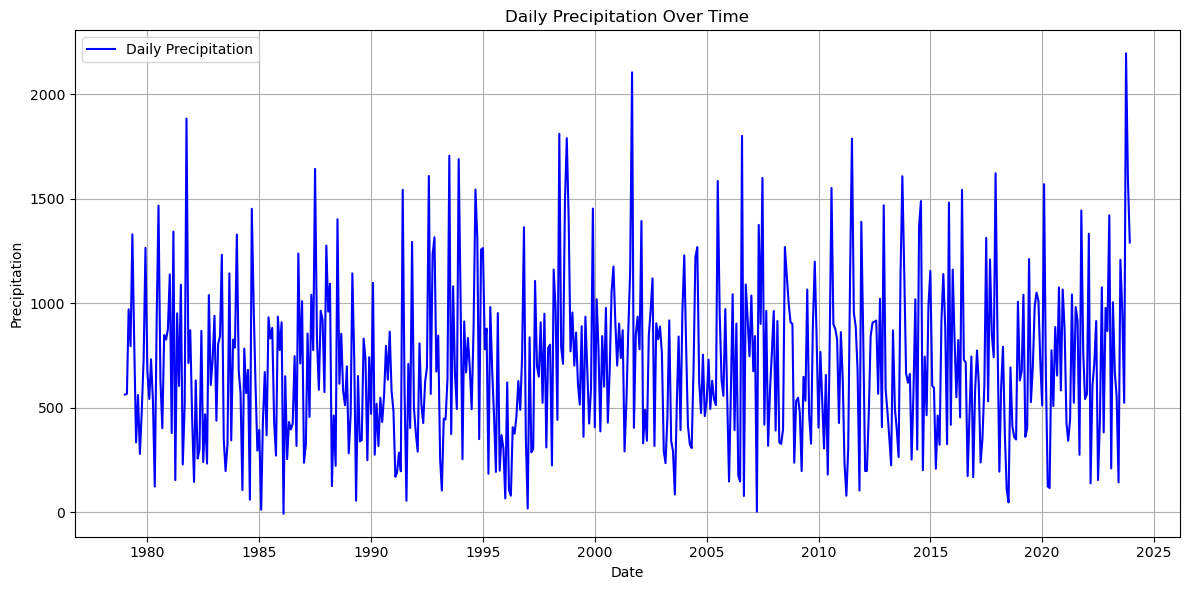

In [14]:
# --------------------------------------------------------------------
# plot the raw data for precipitation and COIs

processor.plot_precip_or_cois(plot_type="precip")


In [15]:
# --------------------------------------------------------------------
# Standardize COI data (after stationarity check)
processor.standardize_COI_data(coi_columns)
# Save the old (non-standardized) COIs for comparison
# processor.df["non_standardized_COIs"] = processor.df[coi_columns] #TODO: check if this works


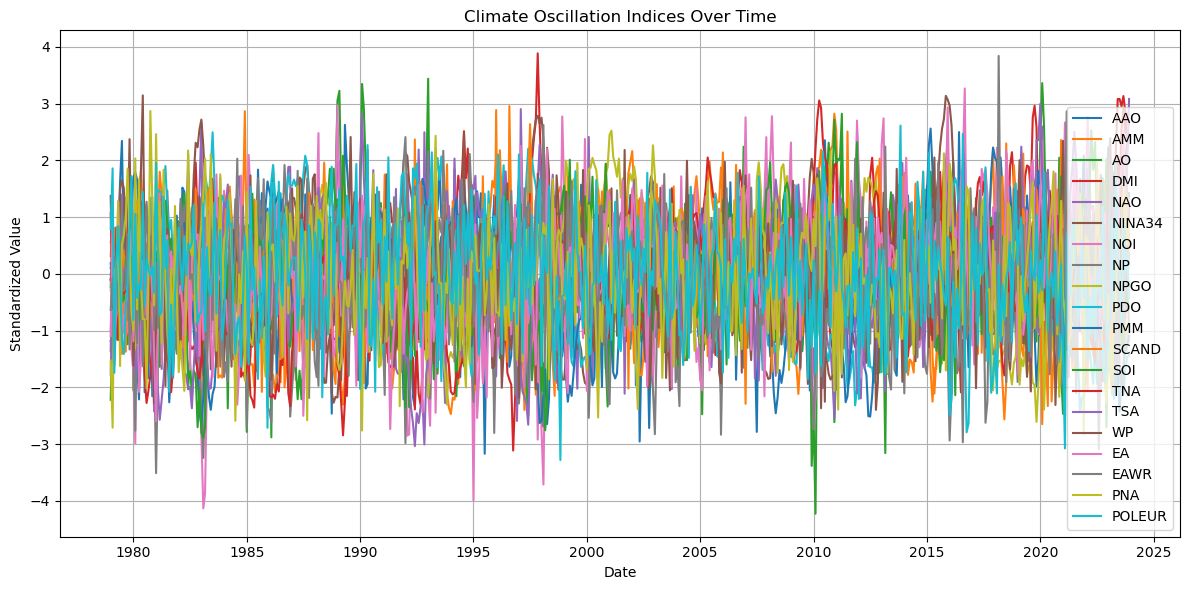

In [16]:
# # Plot COIs
processor.plot_precip_or_cois(plot_type="cois")

In [17]:
# --------------------------------------------------------------------
# 5. Check for missing values and summarize
all_columns = processor.df.columns.tolist()
missing_info = processor.check_missing_values(columns=all_columns)
print("Missing value summary:\n", missing_info)

Missing value summary:
             column_name  num_missing  pct_missing
0                  Date            0          0.0
1   Daily_Precipitation            0          0.0
2                   AAO            0          0.0
3                   AMM            0          0.0
4                    AO            0          0.0
5                   DMI            0          0.0
6                   NAO            0          0.0
7                NINA34            0          0.0
8                   NOI            0          0.0
9                    NP            0          0.0
10                 NPGO            0          0.0
11                  PDO            0          0.0
12                  PMM            0          0.0
13                SCAND            0          0.0
14                  SOI            0          0.0
15                  TNA            0          0.0
16                  TSA            0          0.0
17                   WP            0          0.0
18                   EA   

Heatmap saved to figures/Correlation_matrix


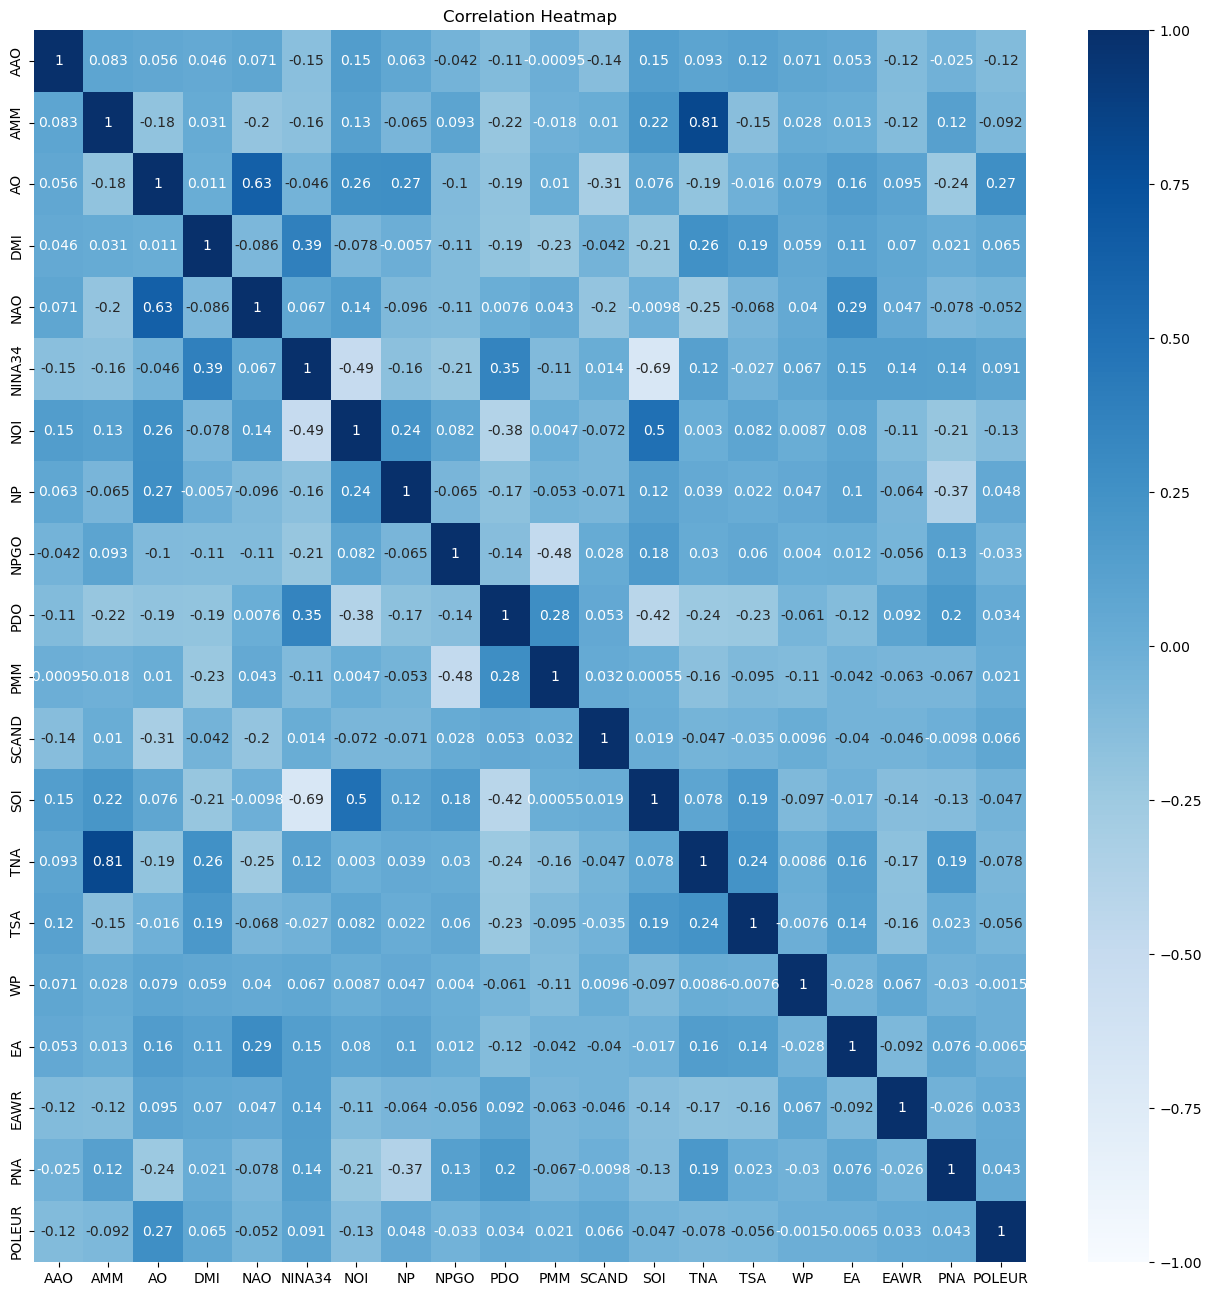

In [18]:
# --------------------------------------------------------------------
# 6. Make a correlation heatmap
processor.plot_correlation_heatmap(columns=coi_columns, save_path='figures/Correlation_matrix')

In [19]:
# --------------------------------------------------------------------
# 7. Remove seasonality in precipitation: After seasonality removal, 'precip_anomaly' is created
processor.remove_seasonality_precip(
    date_col="Date",
    precip_col="Daily_Precipitation"
)


In [20]:
# --------------------------------------------------------------------
# 8. Test stationarity for precipitation anomaly
adf_result_anomaly = processor.stationarity_tester(processor.df["precip_anomaly"])
print("Stationarity test for precipitation anomaly:", adf_result_anomaly)


Stationarity test for precipitation anomaly: {'test_statistic': -23.119592126376975, 'p_value': 0.0, 'used_lag': 0, 'num_obs': 539, 'critical_values': {'1%': -3.4425405682241816, '5%': -2.8669171671779816, '10%': -2.5696338432333636}, 'is_stationary_at_alpha': True}


In [21]:
# test stationarity for COIs
print("\nStationarity Test Results for Standardized COIs:")

for coi in coi_columns:
    if coi in processor.df.columns:
        adf_result = processor.stationarity_tester(processor.df[coi])
        print(f"\n{coi.upper()} Stationarity Test:")
        print(f"  Test Statistic: {adf_result['test_statistic']:.6f}")
        print(f"  p-Value: {adf_result['p_value']:.6f}")
        print(f"  Critical Values: {adf_result['critical_values']}")
        print(f"  Stationary: {'Yes' if adf_result['is_stationary_at_alpha'] else 'No'}")
    else:
        print(f"  {coi} not found in the DataFrame.")


Stationarity Test Results for Standardized COIs:

AAO Stationarity Test:
  Test Statistic: -9.687633
  p-Value: 0.000000
  Critical Values: {'1%': -3.4425861905056556, '5%': -2.8669372502674824, '10%': -2.5696445454608505}
  Stationary: Yes

AMM Stationarity Test:
  Test Statistic: -4.076531
  p-Value: 0.001059
  Critical Values: {'1%': -3.442843345332837, '5%': -2.867050445147657, '10%': -2.5697048674984457}
  Stationary: Yes

AO Stationarity Test:
  Test Statistic: -16.895988
  p-Value: 0.000000
  Critical Values: {'1%': -3.4425405682241816, '5%': -2.8669171671779816, '10%': -2.5696338432333636}
  Stationary: Yes

DMI Stationarity Test:
  Test Statistic: -7.189835
  p-Value: 0.000000
  Critical Values: {'1%': -3.442563336759378, '5%': -2.866927190004947, '10%': -2.5696391843672695}
  Stationary: Yes

NAO Stationarity Test:
  Test Statistic: -19.452340
  p-Value: 0.000000
  Critical Values: {'1%': -3.4425405682241816, '5%': -2.8669171671779816, '10%': -2.5696338432333636}
  Stationar

In [22]:
# --------------------------------------------------------------------
# 9. Test heteroskedasticity (example: regress Precip on some COIs)
test_cols = ["nao.long", "tna"]  # just as an example
het_results = processor.heteroskedasticity_tester(
    y_col="precip_anomaly",
    x_cols=coi_columns  # Or specific test columns
)
print("\nHeteroskedasticity test results:", het_results)



Heteroskedasticity test results: {'Breusch-Pagan_Statistic': 26.139015308180483, 'Breusch-Pagan_pvalue': 0.1612695622741009, 'White_Test_Statistic': 256.8055213885833, 'White_Test_pvalue': 0.1083939938186625}


In [23]:
# --------------------------------------------------------------------
# 10. Test serial correlation (Durbin-Watson)
dw = processor.serial_correlation_tester(
    y_col="precip_anomaly",
    x_cols=coi_columns  # Or specific test columns
)
print(f"\nDurbin-Watson statistic = {dw:.3f} (2 ~ no autocorrelation)")

display(processor.df)


Durbin-Watson statistic = 2.041 (2 ~ no autocorrelation)


,Date,Daily_Precipitation,AAO,AMM,AO,DMI,NAO,NINA34,NOI,NP,...,SOI,TNA,TSA,WP,EA,EAWR,PNA,POLEUR,month,precip_anomaly
936,1979-01-01,562.0,0.102079,0.313030,-2.219162,1.064013,-1.775547,-0.094263,-1.013949,-1.363250,...,-0.236487,-0.114818,-1.180257,1.373088,-1.093787,-0.636915,-1.524875,0.780914,1,-162.800000
937,1979-02-01,566.0,0.251534,0.822345,-0.702285,-0.328759,-0.341273,-0.196293,0.081139,0.378944,...,0.697516,0.168648,-1.412153,-0.616777,1.115328,-0.088983,-2.710745,1.857637,2,-19.711111
938,1979-03-01,970.0,0.803604,0.773300,-0.817829,0.034827,0.298633,0.030441,-0.681402,-0.953052,...,-0.271732,-0.166357,-1.615063,-0.264504,-1.054688,0.003887,0.089503,-1.744490,3,343.622222
939,1979-04-01,794.0,0.578913,0.694073,-1.156558,-0.472435,-0.435053,0.075788,-0.319553,0.686647,...,-0.412714,0.194417,-0.687477,0.820876,-0.751668,0.236061,-0.139699,0.164246,4,361.000000
940,1979-05-01,1329.0,0.625681,0.792164,-0.260850,-1.167355,0.552389,-0.230303,-0.080364,0.186629,...,0.565346,0.349035,-0.513554,-0.112170,1.281501,-0.674063,1.275373,0.839644,5,720.933333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1471,2023-08-01,958.0,-0.149047,0.992117,-0.608468,2.553545,-0.964631,1.583572,-0.670158,0.773188,...,-1.249792,2.951766,0.732890,-0.340671,1.867992,-2.085686,0.428323,-0.941842,8,213.644444
1472,2023-09-01,523.0,-1.177950,2.037157,0.300078,2.908336,-0.357823,1.866991,-0.089904,0.696699,...,-1.038320,3.132153,0.443019,1.287400,2.522907,-1.890659,0.846866,0.849433,9,-209.111111
1473,2023-10-01,2195.0,0.433524,1.957931,-0.422809,2.491970,-0.677776,2.003031,-1.291639,-0.179861,...,-0.368657,2.848687,0.472006,-0.778632,1.037130,0.663263,1.494610,0.017420,10,1345.822222
1474,2023-11-01,1591.0,-0.011792,1.388252,-0.049515,2.832100,-0.236461,2.343133,-1.022467,-0.101624,...,-0.632998,2.255986,1.921360,0.573333,1.027355,0.217488,0.518011,0.379590,11,797.022222


## 1.2a. LASSO & Bootstrapping function

In [25]:
def perform_LASSOs_and_bootstraps(y_col, all_coi_cols, related_processor):
    """
    Demonstrates how to call run_lasso() plus the new LassoBootstrap
    for 'modified_wild_bootstrap', in 3 scenarios:
      1) manual alpha=0.1, no CV, no lags
      2) CV alpha, no lags
      3) CV alpha, lags=3
    """

    estimator = LassoEstimator(random_state=2023)
    bootstrapper = LassoBootstrap(estimator)

    # 1) manual alpha=0.1, no CV, no lags
    print("--- manual alpha, no lags ---")
    results_manual_lasso = estimator.run_lasso(
        df=related_processor.df,
        y_col=y_col,
        x_cols=all_coi_cols,
        alpha=0.1,
        use_cv=False,
        max_lag=0
    )
    results_manual_modwild = bootstrapper.modified_wild_bootstrap(
        df=related_processor.df,
        y_col=y_col,
        x_cols=all_coi_cols,
        alpha_val=0.1,
        use_cv=False,
        max_lag=0,
        B=1000,
        threshold=0.01,
        random_state=123
    )

    # 2) CV alpha, no lags
    print("\n--- CV alpha, no lags ---")
    results_cv_lasso = estimator.run_lasso(
        df=related_processor.df,
        y_col=y_col,
        x_cols=all_coi_cols,
        alpha=None,
        use_cv=True,  # LassoCV
        max_lag=0
    )
    results_cv_modwild = bootstrapper.modified_wild_bootstrap(
        df=related_processor.df,
        y_col=y_col,
        x_cols=all_coi_cols,
        alpha_val=None,
        use_cv=True,
        max_lag=0,
        B=1000,
        threshold=0.01,
        random_state=123
    )

    # 3) CV alpha, lags=3
    print("\n--- CV alpha, lags ---")
    results_lags_lasso = estimator.run_lasso(
        df=related_processor.df,
        y_col=y_col,
        x_cols=all_coi_cols,
        alpha=None,
        use_cv=True,
        max_lag=11
    )
    results_lags_modwild = bootstrapper.modified_wild_bootstrap(
        df=related_processor.df,
        y_col=y_col,
        x_cols=all_coi_cols,
        alpha_val=None,
        use_cv=True,
        max_lag=11,
        B=1000,
        threshold=0.01,
        random_state=123
    )

    return (
        results_manual_lasso,
        results_manual_modwild,
        results_cv_lasso,
        results_cv_modwild,
        results_lags_lasso,
        results_lags_modwild
    )


## 1.2b Analyse all LASSO and bootstrap output

In [27]:
# --------------------------------------------------------------------
# 11. LASSO Analysis for ALL DATA
# --------------------------------------------------------------------

# define y_col and call function
y_col = "precip_anomaly"

(
    results_manual_lasso,
    results_manual_modwild,
    results_cv_lasso,
    results_cv_modwild,
    results_lags_lasso,
    results_lags_modwild
) = perform_LASSOs_and_bootstraps(
    y_col,
    coi_columns,
    processor,
)




--- manual alpha, no lags ---

--- CV alpha, no lags ---

--- CV alpha, lags ---


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
import matplotlib.dates as mdates



def get_lasso_predictions(results_dict, df, y_col, x_cols):
    """
    Reconstruct predicted y from a LASSO results dict.
    x_cols might be lagged_columns or normal COIs, depending on the dictionary.
    We'll do the same logic as run_lasso used to build X.
    We'll do no-lags if results_dict has the normal x_cols, or check 'lagged_columns'.
    """

    alpha_used = results_dict["alpha"]
    if 'coefs_mean' in results_dict:
        coefs = results_dict["coefs_mean"]
        intercept = results_dict["intercept_mean"]
    else:
        coefs = results_dict["coefficients_single"]
        intercept = results_dict["intercept_single"]
    # We also need to see if results_dict has 'lagged_columns'
    lagged_cols = results_dict.get("lagged_columns", x_cols)
    
    # Let's just replicate the logic that we had:
    df_nonan = df[[y_col]+lagged_cols].dropna()  # might skip the first max_lag rows
    X_array = df_nonan[lagged_cols].values
    
    yhat = intercept + X_array.dot(coefs)
    return df_nonan.index, yhat



def plot_predictions_compare(df, y_col, 
                             results_dicts, labels, x_cols, 
                             title="Comparison of Predicted Values", 
                             save_path=None):
    """
    Generates a comparison plot for predicted values.
    
    save_path: Optional. If provided, saves the figure to the given path.
    """

    # Ensure 'Date' is the index
    if not isinstance(df.index, pd.DatetimeIndex):
        df = df.set_index("Date")

    plt.figure(figsize=(12,6))
    
    for rd, lab in zip(results_dicts, labels):
        idx, yhat = get_lasso_predictions(rd, df, y_col, x_cols)
        plt.plot(idx, yhat, label=lab, linestyle='--')

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator(5))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    plt.xticks(rotation=45)
    plt.title(title)
    plt.ylabel("Predicted Precipitation Anomaly")
    plt.legend()
    plt.tight_layout()
    
    #save
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Figure saved to {save_path}")
    
    plt.show()




def compare_coefs_barplot2(results_single, results_mod, x_cols, 
                           title="Coefficient Comparison", 
                           top_n=None, save_path=None):
    """
    Generates a barplot comparing single LASSO and Mod-Wild estimators.
    
    save_path: Optional. If provided, saves the figure to the given path.
    """
    
    coefs_single = results_single["coefficients_single"]
    coefs_mod = results_mod["coefs_mean"]

    abs_means = np.abs(coefs_mod)
    sort_idx = np.argsort(-abs_means)
    
    if top_n is not None:
        sort_idx = sort_idx[:top_n]

    sorted_names = [x_cols[i] for i in sort_idx]
    single_sorted = coefs_single[sort_idx]
    mod_sorted = coefs_mod[sort_idx]

    x_positions = np.arange(len(sort_idx))
    bar_width = 0.35

    plt.figure(figsize=(12,6))
    plt.bar(x_positions - bar_width/2, single_sorted, width=bar_width, label="Single Lasso")
    plt.bar(x_positions + bar_width/2, mod_sorted, width=bar_width, label="Mod Wild Mean")

    plt.xticks(x_positions, sorted_names, rotation=45, ha='right')
    plt.axhline(y=0, color='gray', linestyle='--')
    plt.ylabel("Coefficient Values")
    plt.title(title)
    plt.legend()
    plt.tight_layout()

    #save
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Figure saved to {save_path}")

    plt.show()




def plot_predicted_vs_actual_intervalsAAA(df, y_col, results_dict, base_cols_if_no_lag,
                                          color_pred="#1f77b4", color_actual="#ff7f0e",
                                          title="Predicted vs. Actual with CIs", 
                                          save_path=None):
    """
    Plots actual vs. predicted precipitation anomalies with confidence intervals.
    
    save_path: Optional. If provided, saves the figure to the given path.
    """

    if not isinstance(df.index, pd.DatetimeIndex):
        df = df.set_index("Date")

    lagged_cols = results_dict.get("lagged_columns", base_cols_if_no_lag)

    boot_coefs = results_dict["boot_coefs"]
    boot_intercepts = results_dict.get("boot_intercepts", None)
    if boot_intercepts is None:
        print("Error: results_dict has no 'boot_intercepts' stored!")
        return

    df_nonan = df[[y_col] + lagged_cols].dropna()
    X_array = df_nonan[lagged_cols].values
    n = len(df_nonan)
    B = boot_coefs.shape[0]

    yhat_all = np.zeros((n, B))
    for b in range(B):
        intercept_b = boot_intercepts[b]
        coefs_b = boot_coefs[b, :]
        yhat_all[:, b] = intercept_b + X_array.dot(coefs_b)

    yhat_mean = np.mean(yhat_all, axis=1)
    yhat_p5 = np.percentile(yhat_all, 5, axis=1)
    yhat_p95 = np.percentile(yhat_all, 95, axis=1)

    idx = df_nonan.index

    plt.figure(figsize=(12, 6))

    plt.plot(idx, df_nonan[y_col].values, '-', color=color_actual, label="Actual")
    plt.fill_between(idx, yhat_p5, yhat_p95, color=color_pred, alpha=0.4, label="Predicted 5–95%")
    plt.plot(idx, yhat_mean, '--', color=color_pred, label="Predicted Mean")

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator(5))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    plt.xticks(rotation=45)
    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel("Precipitation Anomaly")
    plt.legend()
    plt.tight_layout()

    #sace
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Figure saved to {save_path}")

    plt.show()




def plot_bootstrap_boxplot_percentilesv2(boot_results, x_cols, 
                                         title="Box Plot (5th–95th)", 
                                         showfliers=True, top_n=None, 
                                         save_path=None):
    """
    Creates a boxplot for bootstrap confidence intervals.
    
    save_path: Optional. If provided, saves the figure to the given path.
    """

    boot_coefs = boot_results["boot_coefs"]
    coefs_mean = boot_results["coefs_mean"]

    abs_means = np.abs(coefs_mean)
    sort_idx = np.argsort(-abs_means)
    
    if top_n is not None:
        sort_idx = sort_idx[:top_n]

    sorted_names = [x_cols[i] for i in sort_idx]
    boot_coefs_sorted = boot_coefs[:, sort_idx]
    means_sorted = coefs_mean[sort_idx]

    df_box = pd.DataFrame(boot_coefs_sorted, columns=sorted_names)

    fig, ax = plt.subplots(figsize=(12,6))
    sns.boxplot(data=df_box, whis=[5,95], showfliers=showfliers, color="skyblue", ax=ax)

    for i, val in enumerate(means_sorted):
        ax.plot(i, val, 'ro')
    ax.axhline(y=0, color='green', linestyle='--')
    ax.set_title(title)
    ax.set_ylabel("Coefficient Inference")
    ax.set_xticklabels(sorted_names, rotation=45, ha='right')
    plt.tight_layout()

    #save
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Figure saved to {save_path}")

    plt.show()


Figure saved to figures/all_year_no_lags_bootstrap_boxplot.png


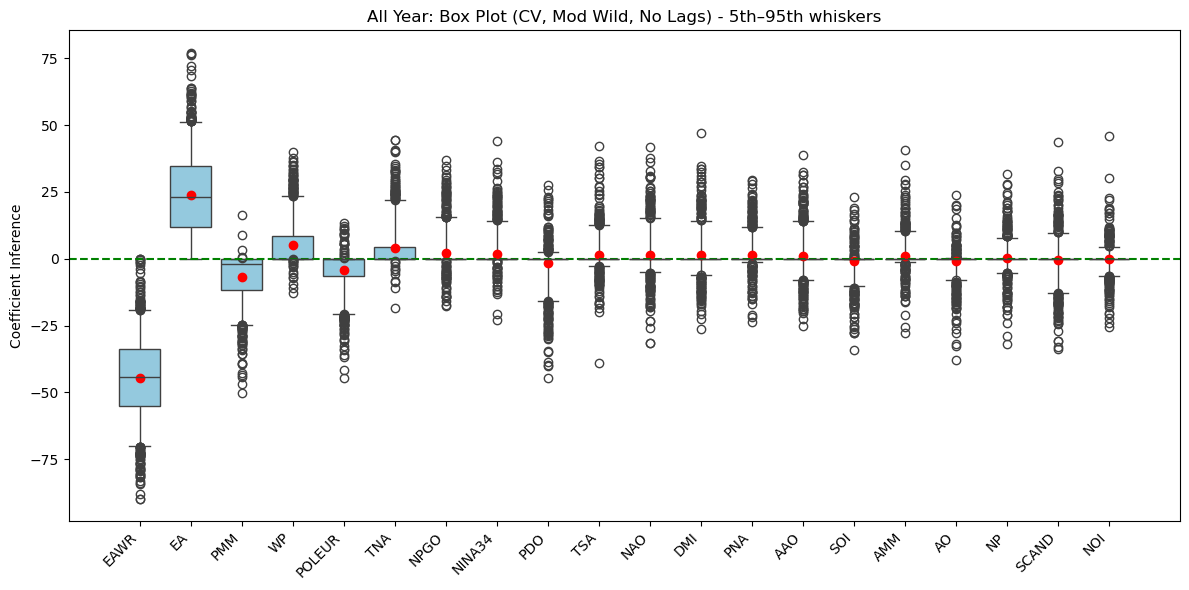

In [32]:
plot_bootstrap_boxplot_percentilesv2(results_cv_modwild, x_cols=coi_columns, title="All Year: Box Plot (CV, Mod Wild, No Lags) - 5th–95th whiskers",
                                    save_path="figures/all_year_no_lags_bootstrap_boxplot.png")

Figure saved to figures/all_year_lags_6_bootstrap_boxplot.png


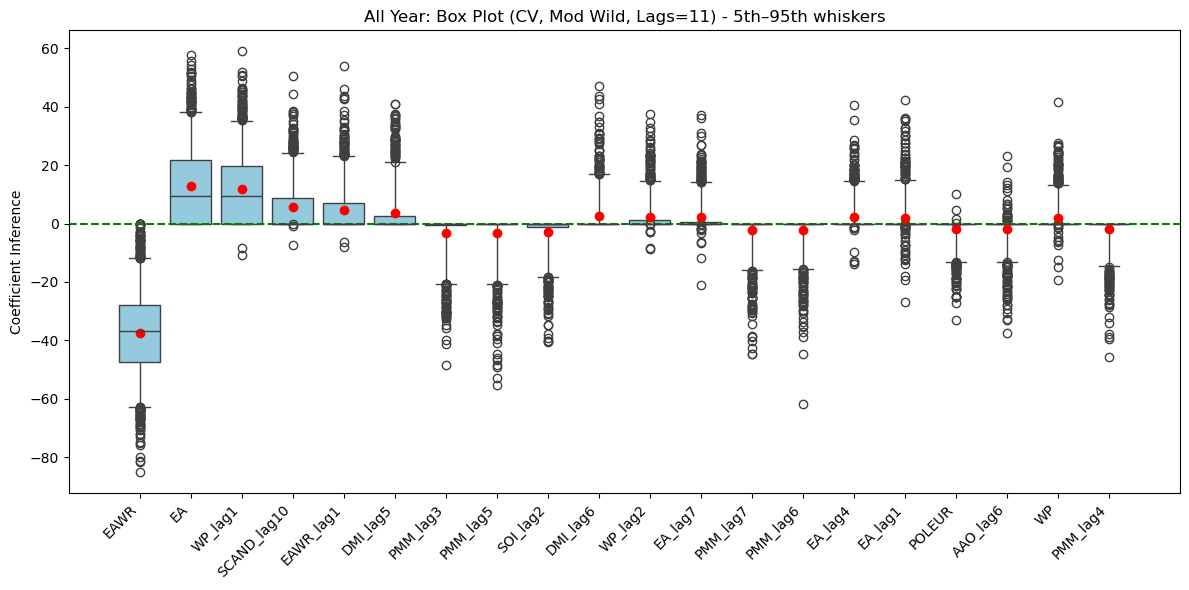

In [33]:
plot_bootstrap_boxplot_percentilesv2(
    results_lags_modwild, 
    x_cols=results_lags_modwild['lagged_columns'],
    title="All Year: Box Plot (CV, Mod Wild, Lags=11) - 5th–95th whiskers",
    top_n=20,
    save_path="figures/all_year_lags_6_bootstrap_boxplot.png"
)


Figure saved to figures/all_year_no_lags_barplot.png


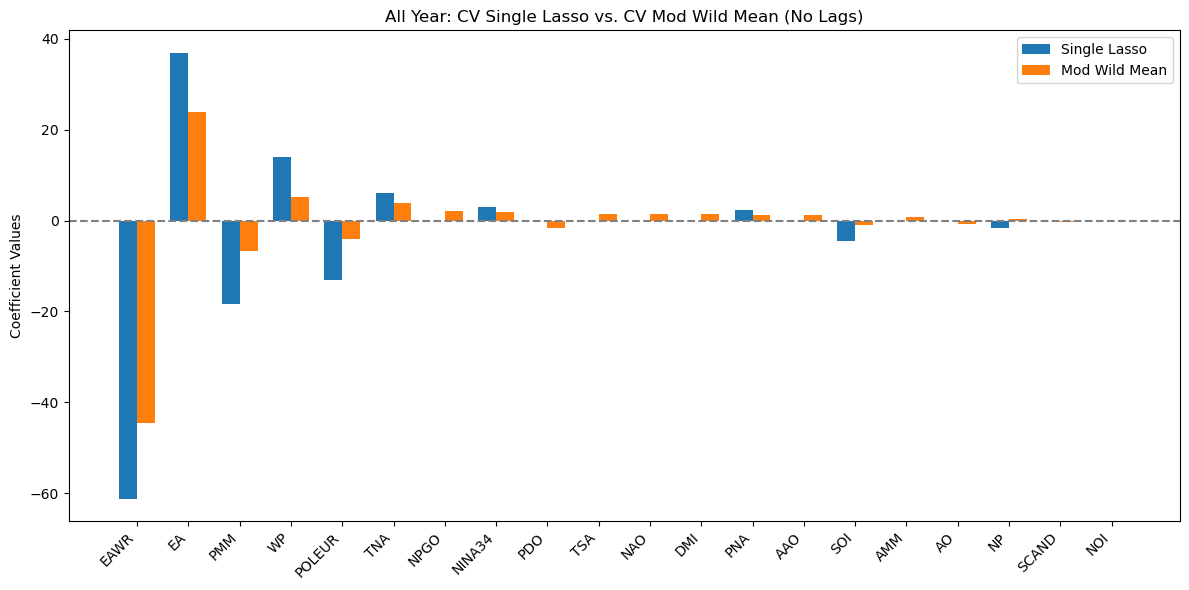

In [34]:
compare_coefs_barplot2(results_cv_lasso, results_cv_modwild, x_cols=coi_columns,
                      title="All Year: CV Single Lasso vs. CV Mod Wild Mean (No Lags)",
                      save_path="figures/all_year_no_lags_barplot.png")

Figure saved to figures/all_year_lags_6_barplot.png


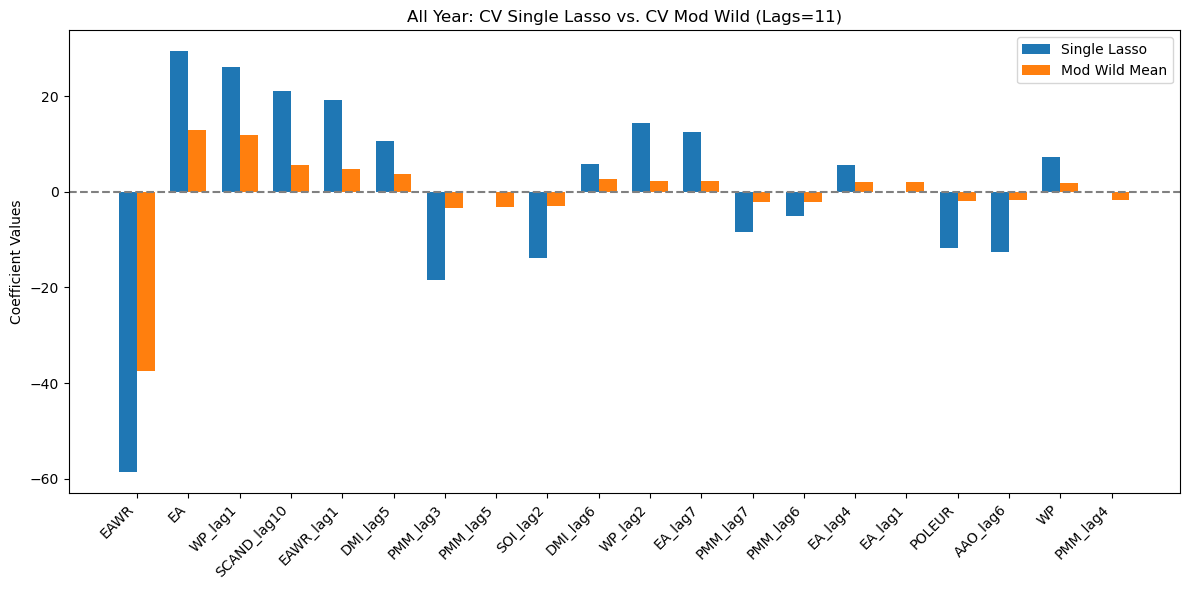

In [35]:
compare_coefs_barplot2(results_lags_lasso, results_lags_modwild, 
                      x_cols=results_lags_lasso["lagged_columns"],
                      title="All Year: CV Single Lasso vs. CV Mod Wild (Lags=11)", top_n=20,
                      save_path="figures/all_year_lags_6_barplot.png")

Figure saved to figures/all_year_no_lags_predicted_actual.png


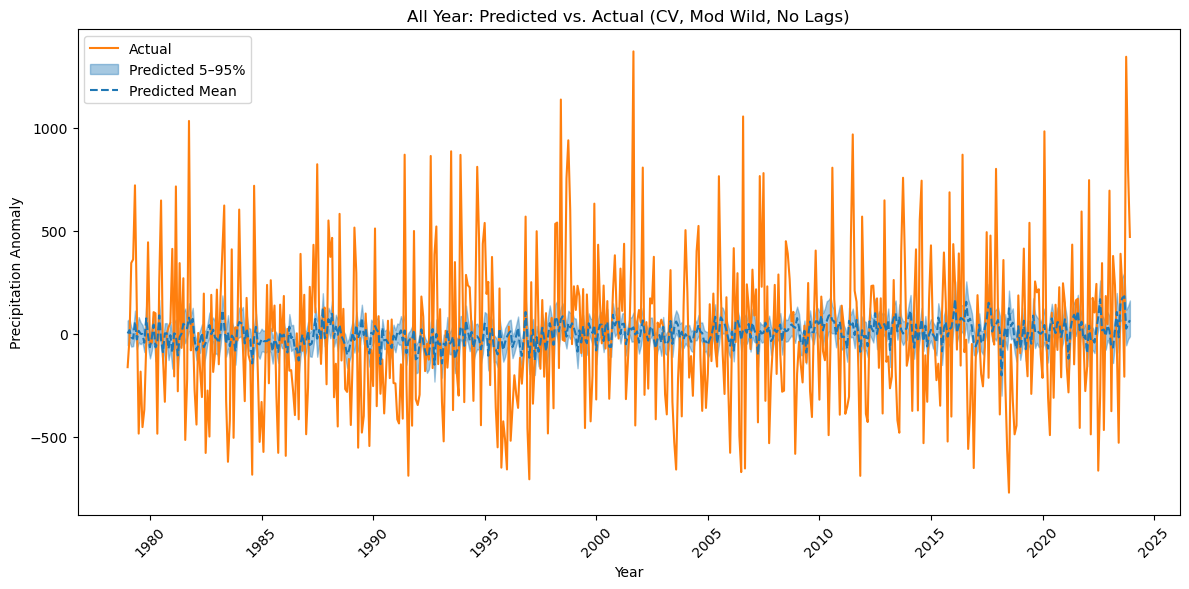

In [36]:
# Make sure your results_dict has "boot_intercepts" if you want intervals
plot_predicted_vs_actual_intervalsAAA(
    df=processor.df,
    y_col="precip_anomaly",
    results_dict=results_cv_modwild, 
    base_cols_if_no_lag=coi_columns,
    color_pred="#1f77b4",
    color_actual="#ff7f0e",
    title="All Year: Predicted vs. Actual (CV, Mod Wild, No Lags)",
    save_path="figures/all_year_no_lags_predicted_actual.png"
)


Figure saved to figures/all_year_no_lags_comparison_predicted.png


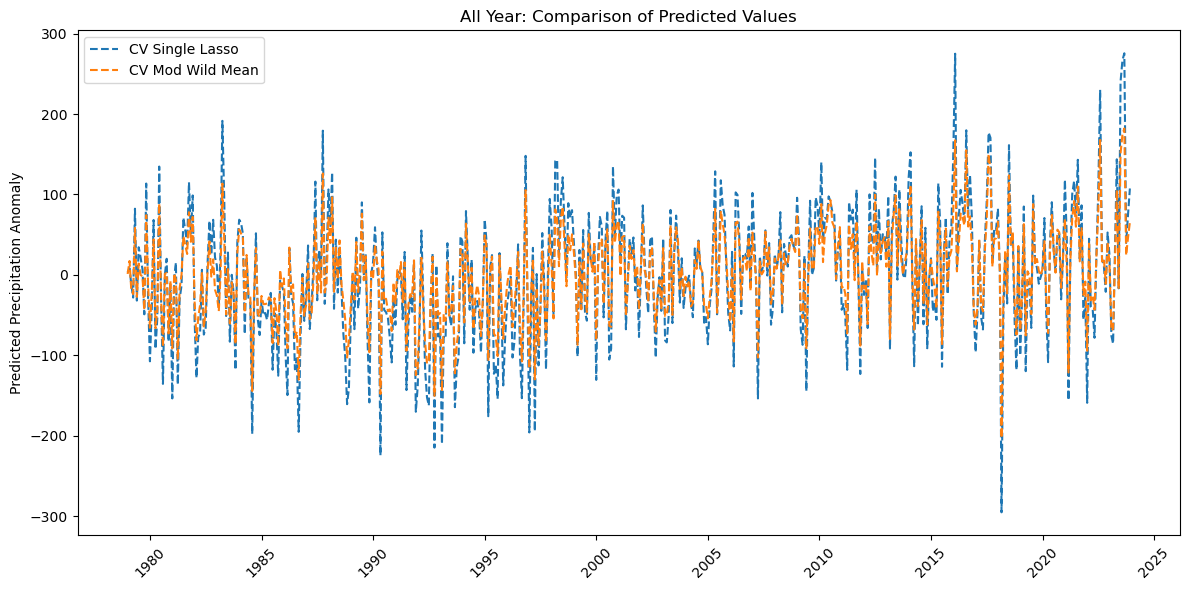

In [37]:
plot_predictions_compare(processor.df, 
                         y_col="precip_anomaly",
                         results_dicts=[results_cv_lasso, results_cv_modwild],
                         labels=["CV Single Lasso", "CV Mod Wild Mean"], 
                         x_cols=coi_columns,
                         title="All Year: Comparison of Predicted Values",
                        save_path="figures/all_year_no_lags_comparison_predicted.png")


In [38]:
def print_nonzero_coefs(results_dict, x_cols, coefs, intercept=None, header="Results"):
    alpha_val = results_dict["alpha"]
    r2 = results_dict.get("r2_score", None)
    intercept_val = results_dict.get(intercept, None)
    coefs_array = results_dict[coefs]  # or coefs_mean if you want the bootstrap means
    p = len(coefs_array)

    print(f"=== {header} ===")
    print(f"Alpha: {alpha_val}")
    if r2 is not None:
        print(f"R^2: {r2:.3f}")
    if intercept_val is not None:
        print(f"Intercept: {intercept_val:.3f}")
    # Build a DataFrame of coefs and filter non-zero
    import pandas as pd
    import numpy as np
    df_coefs = pd.DataFrame({
        "variable": x_cols,
        "coef": coefs_array
    })
    df_coefs["abscoef"] = df_coefs["coef"].abs()
    df_nonzero = df_coefs[df_coefs["coef"] != 0].copy()
    df_nonzero = df_nonzero.sort_values("abscoef", ascending=False)
    print("Non-zero coefficients (sorted by absolute value):")
    for _, row in df_nonzero.iterrows():
        print(f"  {row['variable']}: {row['coef']:.3f}")

    return df_nonzero


In [39]:
COIs_selected_cv_lasso = print_nonzero_coefs(results_cv_lasso, coi_columns, "coefficients_single", "intercept_single", "Lasso CV (No Lags)")
COIs_selected_cv_mod = print_nonzero_coefs(results_cv_modwild, coi_columns, "coefs_mean", "ModWild + CV (No Lags)")


=== Lasso CV (No Lags) ===
Alpha: 15.751459665389223
R^2: 0.083
Intercept: -0.000
Non-zero coefficients (sorted by absolute value):
  EAWR: -61.128
  EA: 36.904
  PMM: -18.312
  WP: 13.993
  POLEUR: -13.018
  TNA: 6.012
  SOI: -4.417
  NINA34: 2.988
  PNA: 2.341
  NP: -1.728
=== Results ===
Alpha: 15.751459665389223
Non-zero coefficients (sorted by absolute value):
  EAWR: -44.513
  EA: 23.798
  PMM: -6.638
  WP: 5.259
  POLEUR: -4.149
  TNA: 3.867
  NPGO: 1.998
  NINA34: 1.889
  PDO: -1.629
  TSA: 1.529
  NAO: 1.482
  DMI: 1.340
  PNA: 1.239
  AAO: 1.117
  SOI: -0.964
  AMM: 0.871
  AO: -0.704
  NP: 0.312
  SCAND: -0.274
  NOI: -0.046


In [40]:
def print_extra_bootstrap_summary(results_dict, x_cols, header="Bootstrap Results"):
    print(f"=== {header} ===")

    alpha_val = results_dict["alpha"]
    print(f"Alpha used: {alpha_val}")
    
    # Single-lasso (original) info
    coefs_single = results_dict["coefficients_single"]
    intercept_single = results_dict["intercept_single"]
    print(f"Single-lasso intercept = {intercept_single:.3f}")

    # If we stored intercept_percentiles:
    if "intercept_percentiles" in results_dict:
        ip5 = results_dict["intercept_percentiles"][5]
        ip95 = results_dict["intercept_percentiles"][95]
        print(f"Bootstrap Intercept 5% ~ {ip5:.3f}, 95% ~ {ip95:.3f}")

    # Bootstrap means
    coefs_mean = results_dict["coefs_mean"]  
    intercept_mean = results_dict.get("intercept_mean", None)
    if intercept_mean is not None:
        print(f"Bootstrap mean intercept = {intercept_mean:.3f}")

    # Confidence intervals
    coefs_percentiles = results_dict["coefs_percentiles"]
    coefs_5 = coefs_percentiles[5]
    coefs_95 = coefs_percentiles[95]

    # Print non-zero coefficients from single-lasso
    df_single = pd.DataFrame({"var": x_cols, "coef": coefs_single})
    df_single = df_single[df_single["coef"] != 0].copy()
    df_single["abscoef"] = df_single["coef"].abs()
    df_single.sort_values("abscoef", ascending=False, inplace=True)
    
    print("Non-zero single-lasso coefficients:")
    for _, row in df_single.iterrows():
        print(f"  {row['var']}: {row['coef']:.3f}")

    # Print top 15 from bootstrap mean
    df_mean = pd.DataFrame({"var": x_cols, "meancoef": coefs_mean, "ci_5": coefs_5, "ci_95": coefs_95})
    df_mean.sort_values("meancoef", key=abs, ascending=False, inplace=True)

    print("\nTop 15 absolute bootstrap-mean coefficients with confidence intervals:")
    print(df_mean.head(15).to_string(index=False))



In [41]:
outp_cv = print_extra_bootstrap_summary(results_cv_modwild, coi_columns)

=== Bootstrap Results ===
Alpha used: 15.751459665389223
Single-lasso intercept = -0.000
Bootstrap Intercept 5% ~ -24.466, 95% ~ 26.051
Bootstrap mean intercept = 0.503
Non-zero single-lasso coefficients:
  EAWR: -61.128
  EA: 36.904
  PMM: -18.312
  WP: 13.993
  POLEUR: -13.018
  TNA: 6.012
  SOI: -4.417
  NINA34: 2.988
  PNA: 2.341
  NP: -1.728

Top 15 absolute bootstrap-mean coefficients with confidence intervals:
   var   meancoef       ci_5      ci_95
  EAWR -44.512986 -70.059164 -19.197289
    EA  23.797691   0.000000  51.288315
   PMM  -6.637779 -24.705823   0.000000
    WP   5.259490   0.000000  23.565148
POLEUR  -4.149262 -20.557226   0.000000
   TNA   3.867413   0.000000  22.109008
  NPGO   1.998122  -0.000000  15.551163
NINA34   1.888915   0.000000  14.279572
   PDO  -1.629326 -15.741160   2.709003
   TSA   1.528686  -2.803998  12.786273
   NAO   1.481889  -4.953614  15.275141
   DMI   1.340313  -6.009377  14.298547
   PNA   1.239161  -1.328317  11.748680
   AAO   1.116877  

In [42]:
outp_lags = print_extra_bootstrap_summary(results_lags_modwild, results_lags_modwild["lagged_columns"])

=== Bootstrap Results ===
Alpha used: 19.777214902305502
Single-lasso intercept = 2.319
Bootstrap Intercept 5% ~ -22.799, 95% ~ 25.023
Bootstrap mean intercept = 1.697
Non-zero single-lasso coefficients:
  EAWR: -58.557
  EA: 29.338
  WP_lag1: 25.995
  SCAND_lag10: 21.143
  EAWR_lag1: 19.271
  PMM_lag3: -18.473
  WP_lag2: 14.328
  SOI_lag2: -13.805
  EA_lag7: 12.565
  AAO_lag6: -12.546
  POLEUR: -11.839
  DMI_lag5: 10.606
  PMM_lag7: -8.494
  WP_lag9: 8.164
  WP: 7.234
  WP_lag7: 6.675
  PNA_lag11: 6.539
  PNA_lag5: 6.399
  DMI_lag6: 5.751
  EA_lag4: 5.574
  PMM_lag6: -5.104
  POLEUR_lag2: -5.047
  EAWR_lag10: 4.510
  EA_lag6: 2.999
  EAWR_lag7: 2.589
  PNA: 2.453
  NOI_lag9: -2.282
  AO_lag10: -2.242
  WP_lag10: 1.795
  PNA_lag3: 1.373
  AAO_lag5: 0.577
  TNA_lag6: 0.304
  POLEUR_lag6: 0.095

Top 15 absolute bootstrap-mean coefficients with confidence intervals:
        var   meancoef       ci_5      ci_95
       EAWR -37.439117 -62.729239 -11.943272
         EA  12.904132   0.000000 

In [43]:
print(COIs_selected_cv_lasso["variable"].tolist())
# --------------------------------------------------------------------
# 9. Test heteroskedasticity (example: regress Precip on some COIs)
test_cols = ["nao.long", "tna"]  # just as an example
het_results = processor.heteroskedasticity_tester(
    y_col="precip_anomaly",
    x_cols=COIs_selected_cv_lasso["variable"].tolist()  # Or specific test columns
)
print("\nHeteroskedasticity test results:", het_results)

['EAWR', 'EA', 'PMM', 'WP', 'POLEUR', 'TNA', 'SOI', 'NINA34', 'PNA', 'NP']

Heteroskedasticity test results: {'Breusch-Pagan_Statistic': 18.917052146078124, 'Breusch-Pagan_pvalue': 0.04132898280789814, 'White_Test_Statistic': 73.24600815325851, 'White_Test_pvalue': 0.22583288348512492}


In [44]:
# --------------------------------------------------------------------
# 10. Test serial correlation (Durbin-Watson)
dw = processor.serial_correlation_tester(
    y_col="precip_anomaly",
    x_cols=COIs_selected_cv_lasso["variable"].tolist()
)
print(f"\nDurbin-Watson statistic = {dw:.3f} (2 ~ no autocorrelation)")


Durbin-Watson statistic = 2.038 (2 ~ no autocorrelation)


# 2. SEASONAL DATA: Winter

## 2.1a Seasonal data: Prepare and Characterize

In [47]:
# Now, we move into seasonal stuff! --> Winter 
seasons_dict = processor.season_splitter(date_col="Date")
df_djf = seasons_dict["winter"]

# 1) Create a new DataProcessor for winter
winter_processor = DataProcessor()
winter_processor.df = df_djf.copy()  # pass the DJF subset

print("\n=== WINTER DATA (DJF) ANALYSIS ===")

# 3) Stationarity Test on the winter precipitation column
#    (Either "Daily_Precipitation" or "precip_anomaly" if you removed seasonality)
y_winter_col = "precip_anomaly"#"Daily_Precipitation"  # or "precip_anomaly"
adf_result_winter = winter_processor.stationarity_tester(winter_processor.df[y_winter_col])
print("Stationarity test (Winter Precip):", adf_result_winter)

# 4) Test stationarity on COIs in winter
#    Identify the COI columns for winter
exclude_cols = ["Date", "Daily_Precipitation", "precip_anomaly", "month"]
coi_winter = [c for c in winter_processor.df.columns if c not in exclude_cols]
print("\nStationarity Test Results for Winter COIs:")
for coi in coi_winter:
    adf_res = winter_processor.stationarity_tester(winter_processor.df[coi])
    print(f"  {coi} => p-value: {adf_res['p_value']:.3f}, Stationary? {adf_res['is_stationary_at_alpha']}")

# 5) Heteroskedasticity Test
#    We can do a quick check, using the same approach as before
het_winter = winter_processor.heteroskedasticity_tester(
    y_col=y_winter_col, 
    x_cols=coi_winter
)
print("\nHeteroskedasticity test results (Winter):", het_winter)

# 6) Serial Correlation (Durbin-Watson)
dw_winter = winter_processor.serial_correlation_tester(
    y_col=y_winter_col,
    x_cols=coi_winter
)
print(f"\nDurbin-Watson (Winter) = {dw_winter:.3f} (2 ~ no autocorr)")



=== WINTER DATA (DJF) ANALYSIS ===
Stationarity test (Winter Precip): {'test_statistic': -11.016935007403728, 'p_value': 6.123185765362769e-20, 'used_lag': 0, 'num_obs': 134, 'critical_values': {'1%': -3.480118600110386, '5%': -2.8833618426136196, '10%': -2.578407034974382}, 'is_stationary_at_alpha': True}

Stationarity Test Results for Winter COIs:
  AAO => p-value: 0.000, Stationary? True
  AMM => p-value: 0.010, Stationary? True
  AO => p-value: 0.000, Stationary? True
  DMI => p-value: 0.000, Stationary? True
  NAO => p-value: 0.000, Stationary? True
  NINA34 => p-value: 0.000, Stationary? True
  NOI => p-value: 0.000, Stationary? True
  NP => p-value: 0.000, Stationary? True
  NPGO => p-value: 0.162, Stationary? False
  PDO => p-value: 0.001, Stationary? True
  PMM => p-value: 0.000, Stationary? True
  SCAND => p-value: 0.000, Stationary? True
  SOI => p-value: 0.000, Stationary? True
  TNA => p-value: 0.001, Stationary? True
  TSA => p-value: 0.000, Stationary? True
  WP => p-va

In [48]:

## make some plots
## check more descriptive stats


## 2.2. Analyse LASSO and Bootstrap

In [50]:

# perform lasso and bootstrap
(
    results_manual_lasso_winter,
    results_manual_modwild_winter,
    results_cv_lasso_winter,
    results_cv_modwild_winter,
    results_lags_lasso_winter,
    results_lags_modwild_winter,
) = perform_LASSOs_and_bootstraps(
    y_winter_col,
    coi_winter,
    winter_processor
)



# # 7a) Manual alpha
# print("\n--- LASSO (Manual alpha) for WINTER ---")
# print(f"Chosen alpha: {results_manual_lasso_winter['alpha']}")
# print("Coefficients (top 10 shown):")
# print(results_manual_lasso_winter["coefficients"].sort_values(key=abs, ascending=False).head(50))
# print(f"Intercept: {results_manual_lasso_winter['intercept']:.3f}")
# print(f"R^2: {results_manual_lasso_winter['r2_score']:.3f}")

# # 7b) LASSO with Cross-Validation
# print("\n--- LASSO (CV) for WINTER ---")
# print(f"Optimal alpha: {results_cv_lasso_winter['alpha']}")
# print("Coefficients (top 10 shown):")
# print(results_cv_lasso_winter["coefficients"].sort_values(key=abs, ascending=False).head(20))
# print(f"Intercept: {results_cv_lasso_winter['intercept']:.3f}")
# print(f"R^2: {results_cv_lasso_winter['r2_score']:.3f}")

# # 7c) LASSO with Lags
# print("\n--- LASSO (with Lags + CV) for WINTER ---")
# print(f"Optimal alpha: {results_lags_lasso_winter['alpha']}")
# print("Coefficients (top 10 shown):")
# print(results_lags_lasso_winter["coefficients"].sort_values(key=abs, ascending=False).head(50))
# print(f"Intercept: {results_lags_lasso_winter['intercept']:.3f}")
# print(f"R^2: {results_lags_lasso_winter['r2_score']:.3f}")
# print(f"Number of columns after lagging: {len(results_lags_lasso_winter['lagged_columns'])}")

--- manual alpha, no lags ---

--- CV alpha, no lags ---

--- CV alpha, lags ---


In [51]:
COIs_selected_cv_lasso_winter = print_nonzero_coefs(results_cv_lasso_winter, coi_winter, "coefficients_single", "intercept_single", "Lasso CV (No Lags)")
COIs_selected_cv_mod_winter = print_nonzero_coefs(results_cv_modwild_winter, coi_winter, "coefs_mean", "ModWild + CV (No Lags)")
print(COIs_selected_cv_lasso_winter["variable"].tolist())

=== Lasso CV (No Lags) ===
Alpha: 6.2117459962861705
R^2: 0.515
Intercept: -62.022
Non-zero coefficients (sorted by absolute value):
  EAWR: -168.905
  NAO: 156.646
  PNA: 63.304
  AAO: 60.689
  SCAND: -59.533
  AO: -42.527
  PDO: -40.392
  NOI: -36.230
  WP: 34.081
  TNA: 29.304
  EA: 23.679
  DMI: 20.252
  SOI: -14.294
  POLEUR: 10.844
  PMM: 10.564
=== Results ===
Alpha: 6.2117459962861705
Non-zero coefficients (sorted by absolute value):
  EAWR: -162.425
  NAO: 124.478
  AAO: 56.924
  PNA: 48.831
  SCAND: -43.346
  NOI: -27.132
  PDO: -24.697
  WP: 21.390
  EA: 19.465
  TNA: 19.404
  DMI: 16.880
  NP: -16.382
  AO: -10.532
  NINA34: 9.830
  AMM: 9.198
  TSA: 7.766
  SOI: -7.650
  POLEUR: -1.587
  NPGO: -1.235
  PMM: 0.248
['EAWR', 'NAO', 'PNA', 'AAO', 'SCAND', 'AO', 'PDO', 'NOI', 'WP', 'TNA', 'EA', 'DMI', 'SOI', 'POLEUR', 'PMM']


In [52]:
# 5) Heteroskedasticity Test
#    We can do a quick check, using the same approach as before
top_coefs_tester = ['EAWR']
het_winter = winter_processor.heteroskedasticity_tester(
    y_col=y_winter_col, 
    x_cols=top_coefs_tester#COIs_selected_cv_lasso_winter["variable"].tolist()
)
print("\nHeteroskedasticity test results (Winter):", het_winter)

# 6) Serial Correlation (Durbin-Watson)
dw_winter = winter_processor.serial_correlation_tester(
    y_col=y_winter_col,
    x_cols=top_coefs_tester#COIs_selected_cv_lasso_winter["variable"].tolist()
)
print(f"\nDurbin-Watson (Winter) = {dw_winter:.3f} (2 ~ no autocorr)")


Heteroskedasticity test results (Winter): {'Breusch-Pagan_Statistic': 2.999539639476932, 'Breusch-Pagan_pvalue': 0.08328817980702886, 'White_Test_Statistic': 3.3033480633152905, 'White_Test_pvalue': 0.19172867994238066}

Durbin-Watson (Winter) = 1.802 (2 ~ no autocorr)


## Heteroscadasticity and Autocorrelation Test on Residuals & Raw Data - Archit

In [54]:
resid = np.array(results_cv_lasso_winter['residuals'])

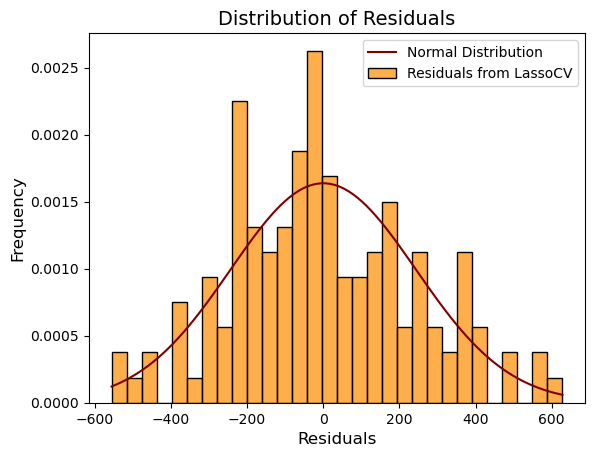

In [55]:
# Generating a normal distribution
mean_residuals = np.mean(resid)
std_residuals = np.std(resid)
x_vals = np.linspace(resid.min(), resid.max(), 100)
normal_pdf = norm.pdf(x_vals, loc=mean_residuals, scale=std_residuals)

sns.histplot(resid, bins=30, kde=False, stat="density", color='darkorange', alpha=0.7, label='Residuals from LassoCV')
plt.plot(x_vals, normal_pdf, color='maroon', label='Normal Distribution')

plt.title('Distribution of Residuals', fontsize=14)
plt.xlabel('Residuals', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.grid(False)
plt.show()

### Heteroskedasticity test

In [57]:
het_winter = winter_processor.heteroskedasticity_tester(
    y_col=y_winter_col, 
    x_cols=coi_winter
)
print("\nHeteroskedasticity test results (Winter):", het_winter)


Heteroskedasticity test results (Winter): {'Breusch-Pagan_Statistic': 25.340609907861225, 'Breusch-Pagan_pvalue': 0.1887095243829983, 'White_Test_Statistic': 135.0, 'White_Test_pvalue': 0.45951888044828637}


### Autocorrelation Test

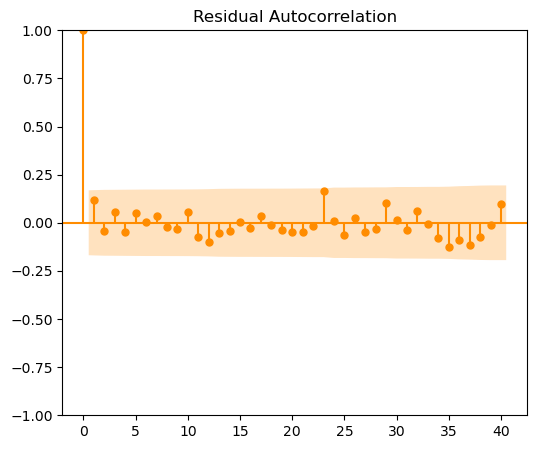

In [59]:
curr_fig, curr_ax = plt.subplots(figsize=(6, 5))
my_color="darkorange"
sm.graphics.tsa.plot_acf(resid, lags=40, ax=curr_ax, color=my_color, vlines_kwargs={"colors": my_color})
for item in curr_ax.collections:
    if type(item)==PolyCollection:
        item.set_facecolor(my_color)
plt.title("Residual Autocorrelation")
plt.show()

In [60]:
# Raw Data

In [61]:
def check_autocorrelation(data, significance_level=0.5, max_lag=20):
    autocorr_results = {}

    for col in data.columns:
        series = data[col]
        
        # Compute ACF and Q-statistics
        acf_values, confint = acf(series, nlags=max_lag, alpha=0.05)

        sig = []
        for i in list(acf_values):
            if i > significance_level:
                sig.append(list(acf_values).index(i))
            

        # Check if there are significant lags
        if len(sig) > 1:
            print(f"'{col}' is autocorrelated up to lags: {sig}")
            #autocorr_results[col] = sig
        else:
            print(f"'{col}' shows no significant autocorrelation.")
            #autocorr_results[col] = []

    return ''

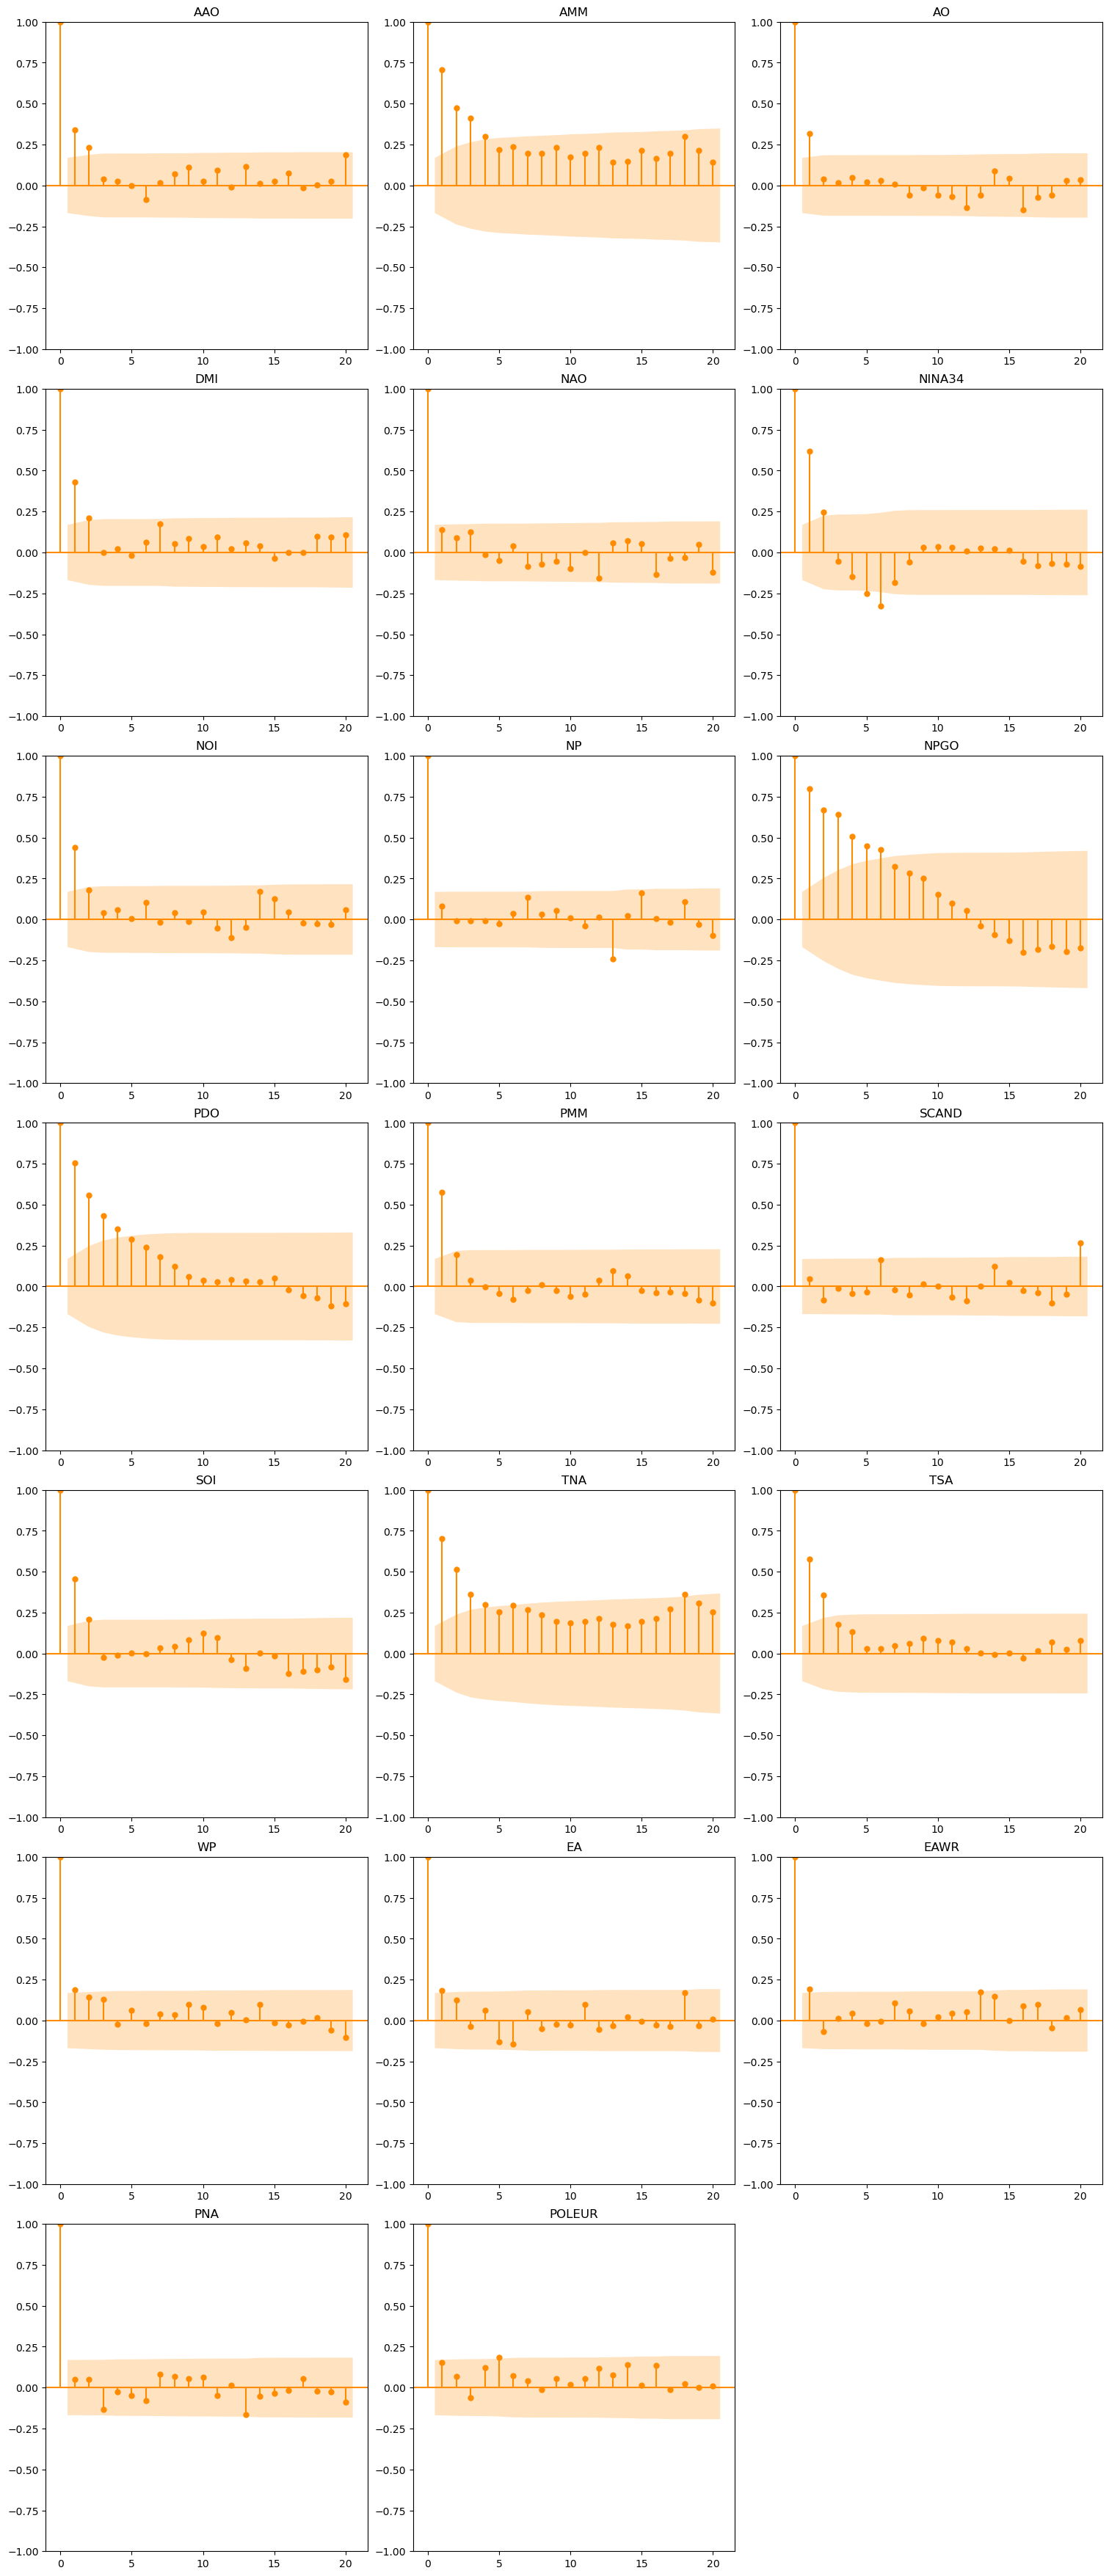

In [62]:
columns = coi_winter  # List of column names
num_plots = len(columns)

# Create subplots: Adjust the number of rows and columns for your layout
rows = (num_plots // 3) + (num_plots % 3 > 0)  # 3 plots per row
cols = 3  # Adjust columns per row
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5), constrained_layout=True)
axes = axes.flatten()  # Flatten the 2D axes array for easy indexing

my_color = 'darkorange'

# Generate each plot
for idx, col in enumerate(columns):
    curr_ax = axes[idx]
    plot_acf(winter_processor.df[col], lags=20, ax=curr_ax, color=my_color, vlines_kwargs={"colors": my_color})
    
    # Customize bar colors
    for item in curr_ax.collections:
        if isinstance(item, PolyCollection):
            item.set_facecolor(my_color)
    
    curr_ax.set_title(col, fontsize=12)

# Hide empty subplots if any
for i in range(len(columns), len(axes)):
    fig.delaxes(axes[i])

# Show the final plot
plt.show()


In [63]:
print(check_autocorrelation(winter_processor.df[columns]))

'AAO' shows no significant autocorrelation.
'AMM' is autocorrelated up to lags: [0, 1]
'AO' shows no significant autocorrelation.
'DMI' shows no significant autocorrelation.
'NAO' shows no significant autocorrelation.
'NINA34' is autocorrelated up to lags: [0, 1]
'NOI' shows no significant autocorrelation.
'NP' shows no significant autocorrelation.
'NPGO' is autocorrelated up to lags: [0, 1, 2, 3, 4]
'PDO' is autocorrelated up to lags: [0, 1, 2]
'PMM' is autocorrelated up to lags: [0, 1]
'SCAND' shows no significant autocorrelation.
'SOI' shows no significant autocorrelation.
'TNA' is autocorrelated up to lags: [0, 1, 2]
'TSA' is autocorrelated up to lags: [0, 1]
'WP' shows no significant autocorrelation.
'EA' shows no significant autocorrelation.
'EAWR' shows no significant autocorrelation.
'PNA' shows no significant autocorrelation.
'POLEUR' shows no significant autocorrelation.



In [64]:
columns = coi_winter

### Bootstrapping

In [83]:
def moving_block_bootstrap_lasso_modified(
    X, y, block_size, num_bootstrap, lasso_alpha=1.0, threshold=0.01, confidence_alpha=0.05, random_state=42
):
  
    rng = np.random.RandomState(random_state)
    n = X.shape[0]
    p = X.shape[1]

    # Step A: Fit Lasso once on (X, y) to get the "modified" residuals
    base_model = Lasso(alpha=lasso_alpha, random_state=rng.randint(999999))
    base_model.fit(X, y)
    base_coefs = base_model.coef_.copy()

    # Threshold near-zero coefficients
    mask_small = (np.abs(base_coefs) < threshold)
    base_coefs[mask_small] = 0.0

    # Recompute residuals from thresholded solution
    # y_hat_mod = X.dot(base_coefs) + base_model.intercept_   # optionally incorporate intercept
    # But let's do a small correction: after thresholding, we also want
    # to recompute the intercept from a quick OLS-on-residual approach or keep the original:
    intercept_mod = base_model.intercept_

    y_hat_mod = X.dot(base_coefs) + intercept_mod
    resid = y - y_hat_mod

    # Step B: Convert residuals to overlapping blocks
    # We will do i.i.d. sampling of blocks to preserve correlation of the residuals
    num_blocks = n - block_size + 1
    # shape: (num_blocks, block_size)
    blocks_resid = np.array([resid[i : i + block_size] for i in range(num_blocks)])

    # We'll store bootstrap results
    boot_coefs = np.zeros((num_bootstrap, p))
    boot_r2s   = np.zeros(num_bootstrap)
    y_pred_all = np.zeros((num_bootstrap, n))

    # Step C: Loop over bootstrap draws
    for b in range(num_bootstrap):
        # sample block indices (like "sampled_indices"), then tile them to form length ~n
        block_inds = rng.choice(num_blocks, size=(n // block_size + 1), replace=True)
        # Concatenate blocks
        sampled_resid = np.concatenate(blocks_resid[block_inds], axis=0)[:n]

        # Build pseudo-responses
        #   y_star = thresholded_fitted + block-resampled residual
        y_star = y_hat_mod + sampled_resid

        # Now refit Lasso on (X, y_star)
        refit_model = Lasso(alpha=lasso_alpha, random_state=rng.randint(999999))
        refit_model.fit(X, y_star)

        # Step C2: Threshold again on each iteration
        raw_coefs = refit_model.coef_
        coefs_thr = np.where(np.abs(raw_coefs) < threshold, 0.0, raw_coefs)
        boot_coefs[b, :] = coefs_thr

        # Evaluate in-sample R^2 on original data (optional)
        y_pred = X.dot(coefs_thr) + refit_model.intercept_
        boot_r2s[b] = r2_score(y, y_pred)
        y_pred_all[b, :] = y_pred

    # Summaries
    # a) coefficient means
    coefs_mean = boot_coefs.mean(axis=0)

    # b) coefficient confidence intervals
    alpha_lower = 100.0 * (confidence_alpha / 2.0)
    alpha_upper = 100.0 * (1.0 - confidence_alpha / 2.0)
    lower_bounds = np.percentile(boot_coefs, alpha_lower, axis=0)
    upper_bounds = np.percentile(boot_coefs, alpha_upper, axis=0)
    conf_intervals = np.vstack((lower_bounds, upper_bounds)).T

    # c) mean R^2
    mean_r2 = np.mean(boot_r2s)

    # d) predicted distributions
    y_pred_mean = np.mean(y_pred_all, axis=0)
    y_pred_p5   = np.percentile(y_pred_all, 5, axis=0)
    y_pred_p95  = np.percentile(y_pred_all, 95, axis=0)

    return (coefs_mean, conf_intervals, mean_r2,
            y_pred_mean, y_pred_p5, y_pred_p95)

In [164]:
# Modified parameters and function call
block_size = 2
num_bootstrap = 1000
alpha = 0.05 
lasso_alpha = 6.2117459962861705 
X = winter_processor.df[columns]
y = winter_processor.df['precip_anomaly']

coefficients_mean, confidence_intervals, r_squ, y_predicted, y_p5, y_p95 = moving_block_bootstrap_lasso_modified(
    X=X, 
    y=y, 
    block_size=block_size, 
    num_bootstrap=num_bootstrap,
    lasso_alpha=lasso_alpha
)

y_actual = y

coefficients = np.random.normal(
    loc=coefficients_mean,
    scale=(confidence_intervals[:, 1] - confidence_intervals[:, 0]) / 4,
    size=(num_bootstrap, len(coefficients_mean))
)

ind = winter_processor.df.Date.copy()
ind = pd.to_datetime(ind, errors='coerce')
ind = ind.dt.strftime('%Y-%m')

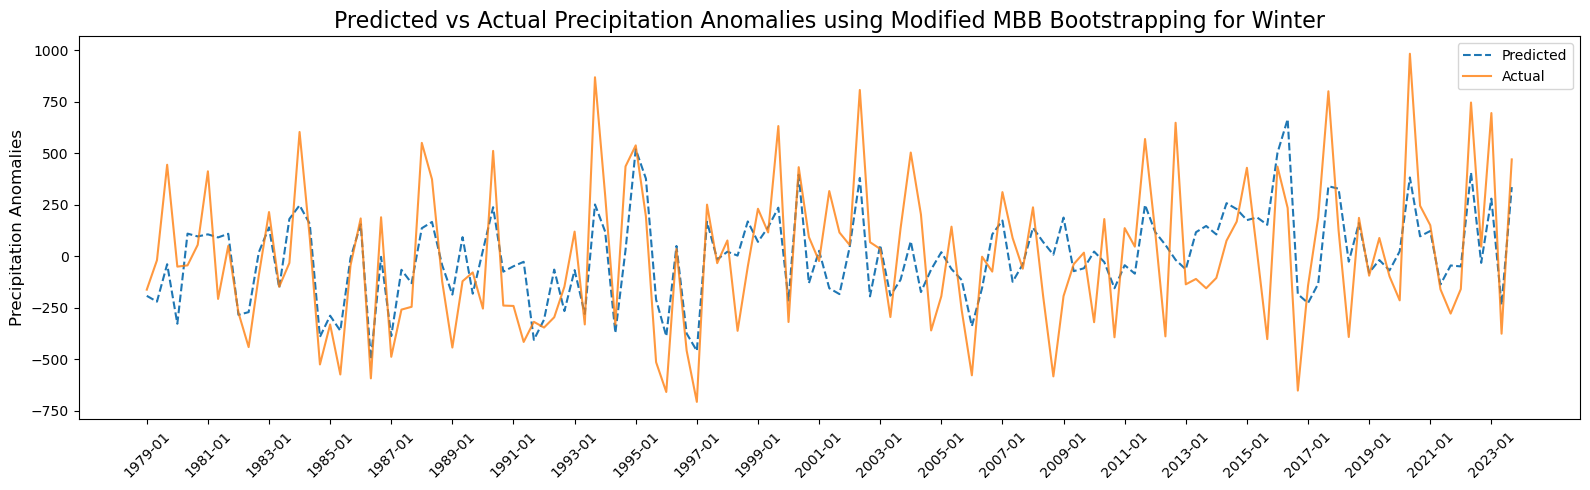

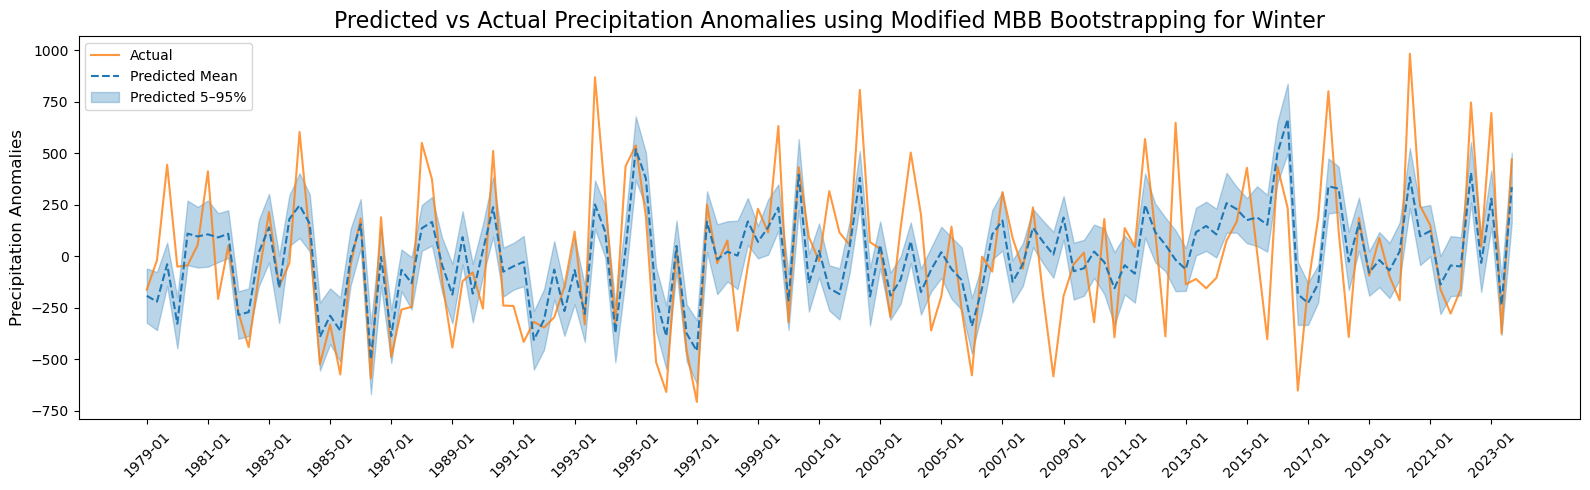

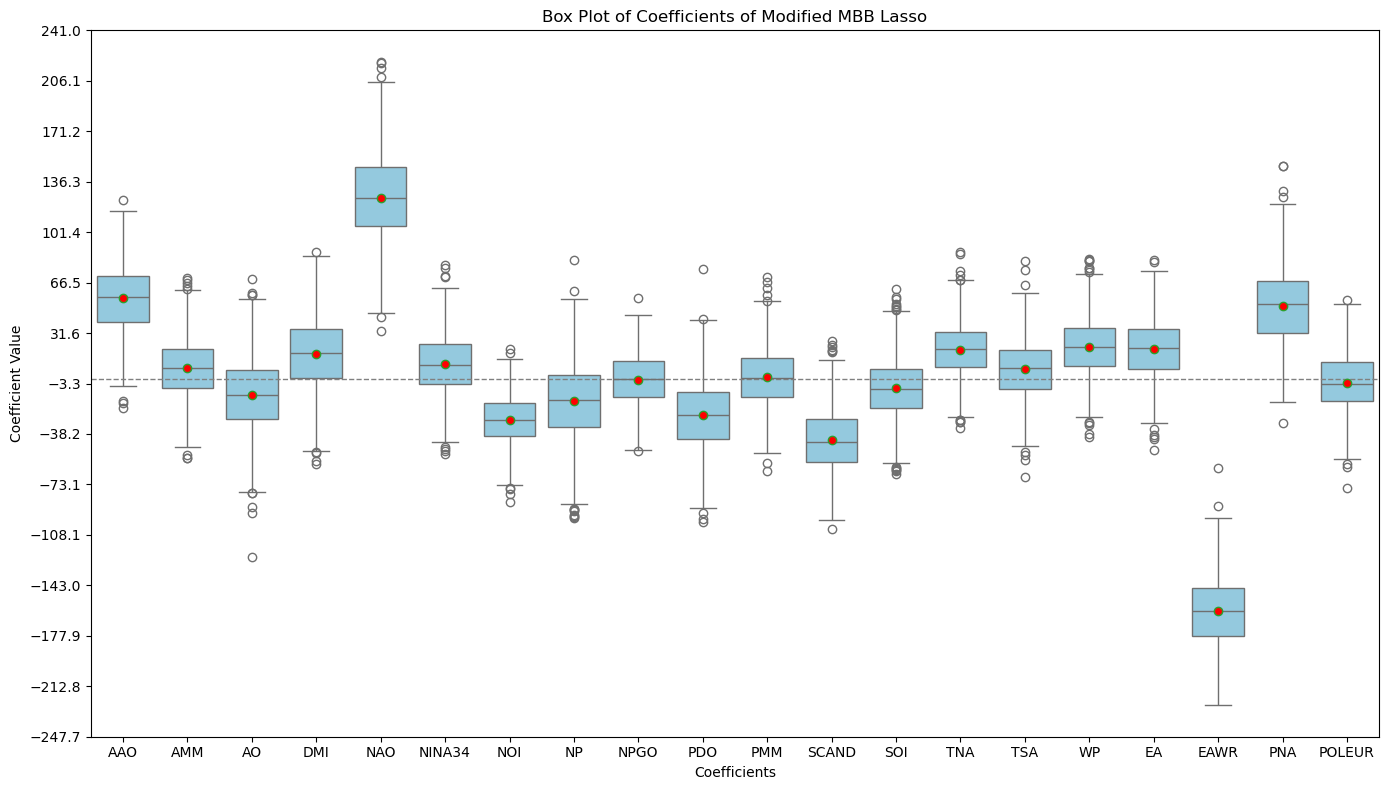

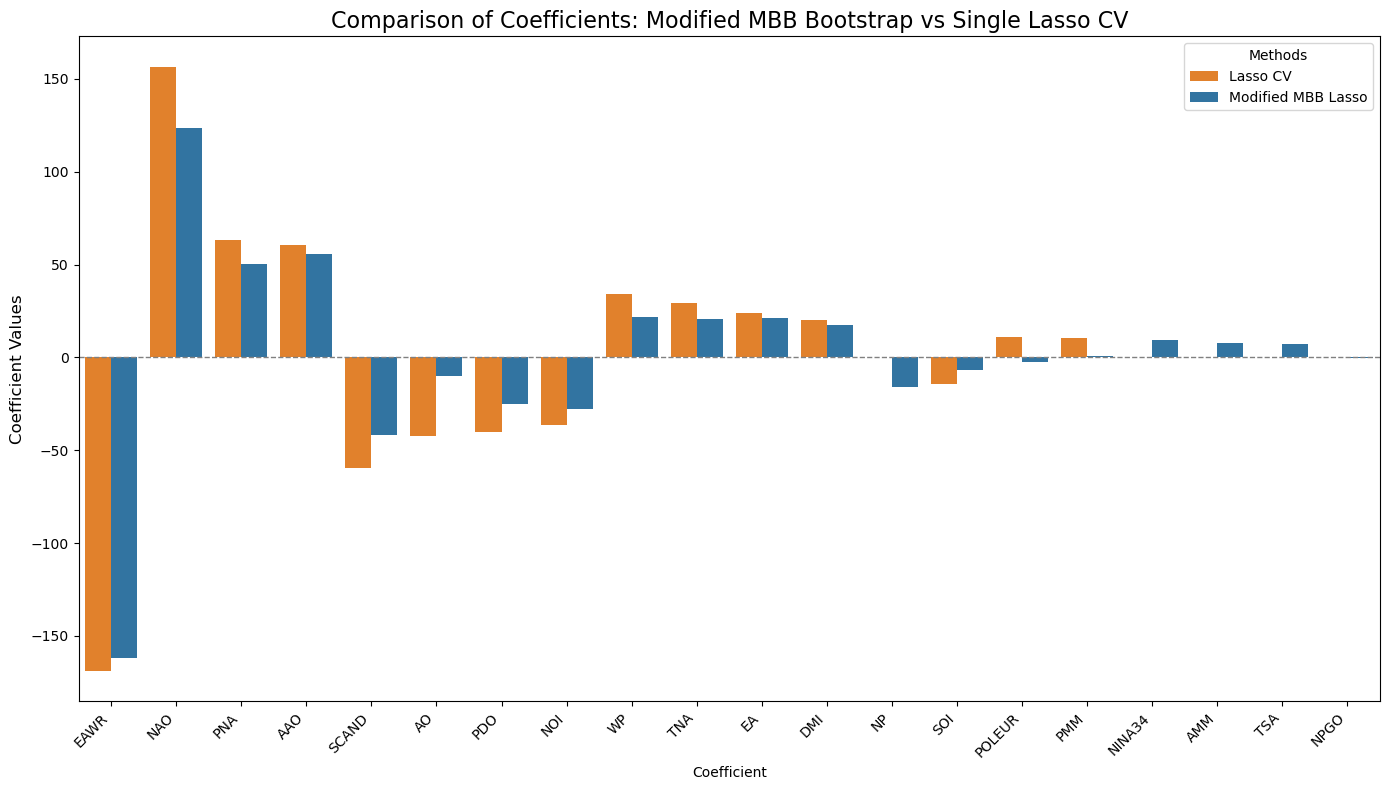

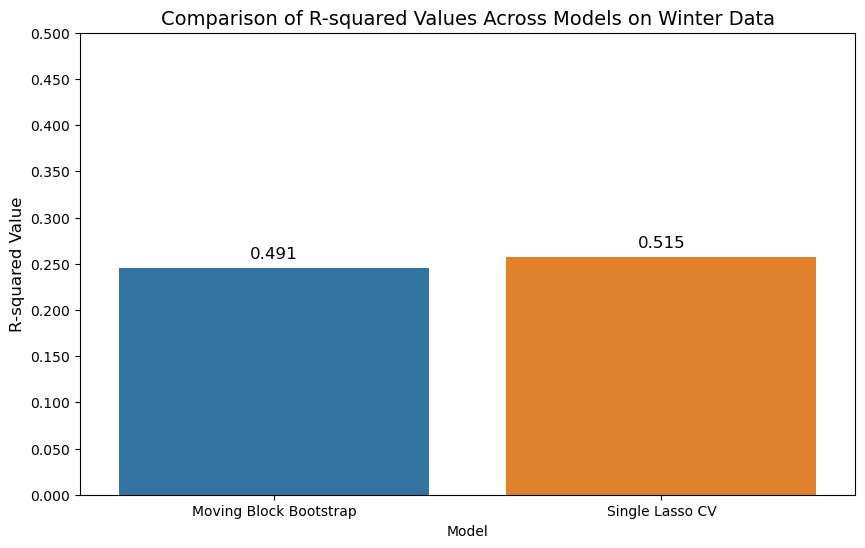

In [165]:
def calculate_r2(y_actual, y_predicted):
    ss_res = np.sum((y_actual - y_predicted) ** 2)
    ss_tot = np.sum((y_actual - np.mean(y_actual)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2


plt.figure(figsize=(16, 5))
plt.plot(ind, y_predicted, label="Predicted", linestyle="--", color="#1f77b4")
plt.plot(ind, y_actual, label="Actual", linestyle="-", color="#ff7f0e", alpha=0.8)
plt.title("Predicted vs Actual Precipitation Anomalies using Modified MBB Bootstrapping for Winter", fontsize=16)
plt.ylabel("Precipitation Anomalies", fontsize=12)
plt.xticks(ind[::6],rotation=45, fontsize=10)
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig(r"C:\Users\archi\OneDrive\Documents\GitHub\bootstrap_case_study\model_all\figures\predicted_vs_actual_winter_data.png", dpi=300, bbox_inches="tight")
plt.show()




plt.figure(figsize=(16, 5))
plt.plot(ind, y_actual, label="Actual", linestyle="-", color="#ff7f0e", alpha=0.8)
plt.plot(ind, y_predicted, label="Predicted Mean", linestyle="--", color="#1f77b4")
plt.fill_between(ind, y_p5, y_p95, color="#1f77b4", alpha=0.3, label="Predicted 5–95%")
plt.title("Predicted vs Actual Precipitation Anomalies using Modified MBB Bootstrapping for Winter", fontsize=16)
plt.ylabel("Precipitation Anomalies", fontsize=12)
plt.xticks(ind[::6], rotation=45, fontsize=10)  # Adjust x-axis ticks for better readability
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig(r"C:\Users\archi\OneDrive\Documents\GitHub\bootstrap_case_study\model_all\figures\predicted_vs_actual_winter_confint.png", dpi=300, bbox_inches="tight")
plt.show()




custom_x_labels = ['AAO', 'AMM', 'AO', 'DMI', 'NAO', 'NINA34', 'NOI', 'NP', 'NPGO', 'PDO', 'PMM', 'SCAND', 'SOI', 'TNA', 'TSA', 'WP', 'EA', 'EAWR', 'PNA', 'POLEUR']
# Ensure positive scale by taking the absolute difference
coefficients = np.random.normal(
    loc=coefficients_mean,
    scale=np.abs(confidence_intervals[:, 1] - confidence_intervals[:, 0]) / 4,
    size=(num_bootstrap, len(coefficients_mean))
)
coeff_data = {
    "Coefficients": np.tile(custom_x_labels, num_bootstrap),
    "Values": coefficients.flatten(),
}
coeff_df = pd.DataFrame(coeff_data)
plt.figure(figsize=(14, 8))
sns.boxplot(x="Coefficients", y="Values", data=coeff_df, showmeans=True, meanprops={"marker": "o", "markerfacecolor": "red"}, color = 'skyblue')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
y_min, y_max = plt.ylim()
y_ticks = np.linspace(y_min, y_max, num=15)
plt.yticks(y_ticks)
plt.title("Box Plot of Coefficients of Modified MBB Lasso")
plt.ylabel("Coefficient Value")
plt.xticks(ticks=range(len(custom_x_labels)), labels=custom_x_labels)
plt.tight_layout()
plt.savefig(r"C:\Users\archi\OneDrive\Documents\GitHub\bootstrap_case_study\model_all\figures\MBB_Lasso_box.png", dpi=300, bbox_inches="tight")
plt.show()






df = pd.DataFrame({
    "Modified MBB Lasso": coefficients_mean,
    "Lasso CV": results_cv_lasso_winter["coefficients_single"]
}, index=columns).reset_index().melt(id_vars="index", var_name="Method", value_name="Coefficient Value")

df.rename(columns={"index": "Coefficient"}, inplace=True)

# Add a column for the absolute values of coefficients for sorting
df['abs_value'] = df['Coefficient Value'].abs()

# Sort the DataFrame by absolute coefficient values in descending order
df = df.sort_values(by='abs_value', ascending=False).drop(columns=['abs_value'])

# Processed x-axis labels based on the sorted coefficients
sorted_labels = df['Coefficient'].unique()

plt.figure(figsize=(14, 8))

# Custom colors for the bar plot
sns.barplot(
    data=df, 
    x="Coefficient", 
    y="Coefficient Value", 
    hue="Method", 
    palette={"Modified MBB Lasso": "#1f77b4", "Lasso CV": "#ff7f0e"}
)

plt.title('Comparison of Coefficients: Modified MBB Bootstrap vs Single Lasso CV', fontsize=16)
plt.ylabel("Coefficient Values", fontsize=12)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# Set custom x-axis labels based on the sorted order
plt.xticks(ticks=range(len(sorted_labels)), labels=sorted_labels, rotation=45, ha="right")

plt.legend(title="Methods", fontsize=10)
plt.tight_layout()
plt.savefig(r"C:\Users\archi\OneDrive\Documents\GitHub\bootstrap_case_study\model_all\figures\coeff_com_mbb_sorted.png", dpi=300, bbox_inches="tight")
plt.show()




r_mbb = calculate_r2(y_actual, y_predicted)
r_lass = results_cv_lasso_winter['r2_score']
r_squared_df = pd.DataFrame({
    "Model": ["Moving Block Bootstrap", "Single Lasso CV"],
    "R-squared": [r_mbb, r_lass]
})
plt.figure(figsize=(10, 6))
custom_colors = ["#1f77b4", "#ff7f0e"]
sns.barplot(data=r_squared_df, x="Model", y="R-squared", palette=custom_colors)
plt.title("Comparison of R-squared Values Across Models on Winter Data", fontsize=14)
plt.ylabel("R-squared Value", fontsize=12)
plt.ylim(0, 1)

plt.yticks(ticks=[i/500 for i in range(0, 501, 50)], labels=[f"{i/1000:.3f}" for i in range(0, 501, 50)])
for index, row in r_squared_df.iterrows():
    plt.text(index, row["R-squared"] + 0.02, f"{row['R-squared']:.3f}", ha='center', fontsize=12)

plt.savefig(r"C:\Users\archi\OneDrive\Documents\GitHub\bootstrap_case_study\model_all\figures\MBB_Lasso_winter_R2.png", dpi=300, bbox_inches="tight")
plt.show()




In [ ]:
# color_pred="#1f77b4",
#     color_actual="#ff7f0e"

In [124]:
#df

## Lagged_Winter

In [167]:
def create_lagged_features(df, x_cols, max_lag):
    df_out = df.copy()
    new_cols = []

    for col in x_cols:
        new_cols.append(col)
        for lag in range(1, max_lag + 1):
            lag_col_name = f"{col}_lag{lag}"
            df_out[lag_col_name] = df_out[col].shift(lag)
            new_cols.append(lag_col_name)

    return df_out, new_cols

a, new_columns = create_lagged_features(winter_processor.df, custom_x_labels, max_lag=11)
a = a.dropna()
y_lag = a["precip_anomaly"].copy()
x_lag = a.drop(["precip_anomaly",'Date','Daily_Precipitation','month'], axis = 1).copy()

In [168]:
# Modified parameters and function call
block_size = 2
num_bootstrap = 1000
alpha = 0.05 
lasso_alpha = 6.2117459962861705 
X = x_lag
y = y_lag

coefficients_mean, confidence_intervals, r_squ, y_predicted, y_p5, y_p95 = moving_block_bootstrap_lasso_modified(
    X=X, 
    y=y, 
    block_size=block_size, 
    num_bootstrap=num_bootstrap, 
    lasso_alpha=lasso_alpha
)
y_actual = y
coefficients = np.random.normal(
    loc=coefficients_mean,
    scale=(confidence_intervals[:, 1] - confidence_intervals[:, 0]) / 4,
    size=(num_bootstrap, len(coefficients_mean))
)

ind = a.Date.copy()
ind = pd.to_datetime(ind, errors='coerce')
ind = ind.dt.strftime('%Y-%m')



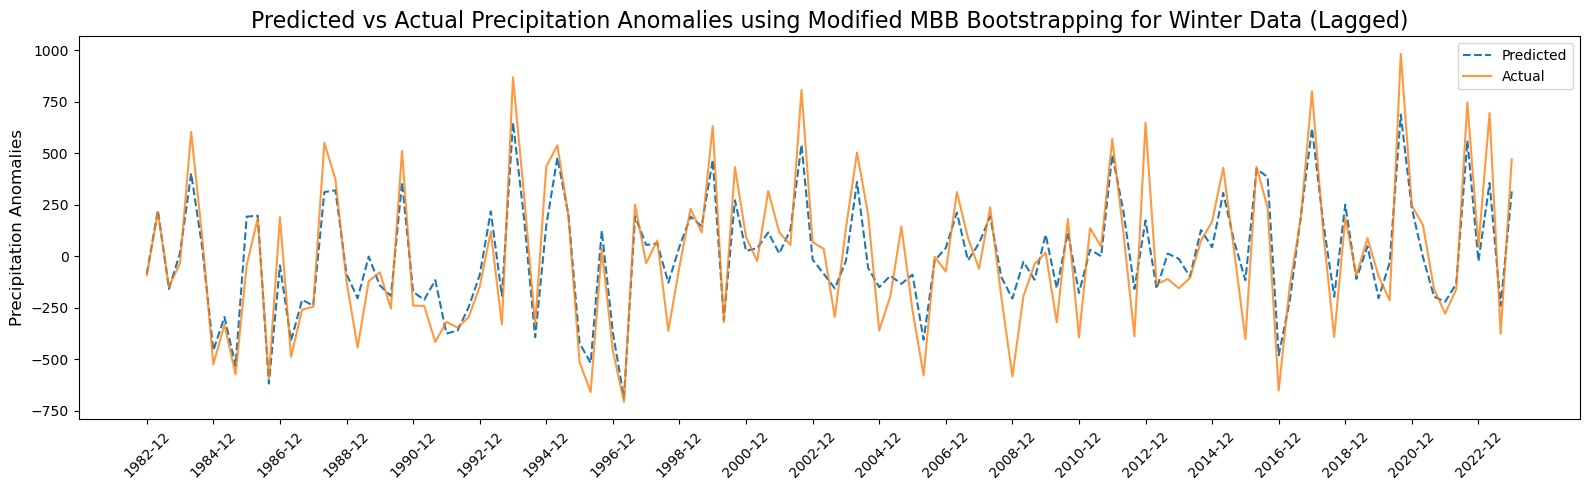

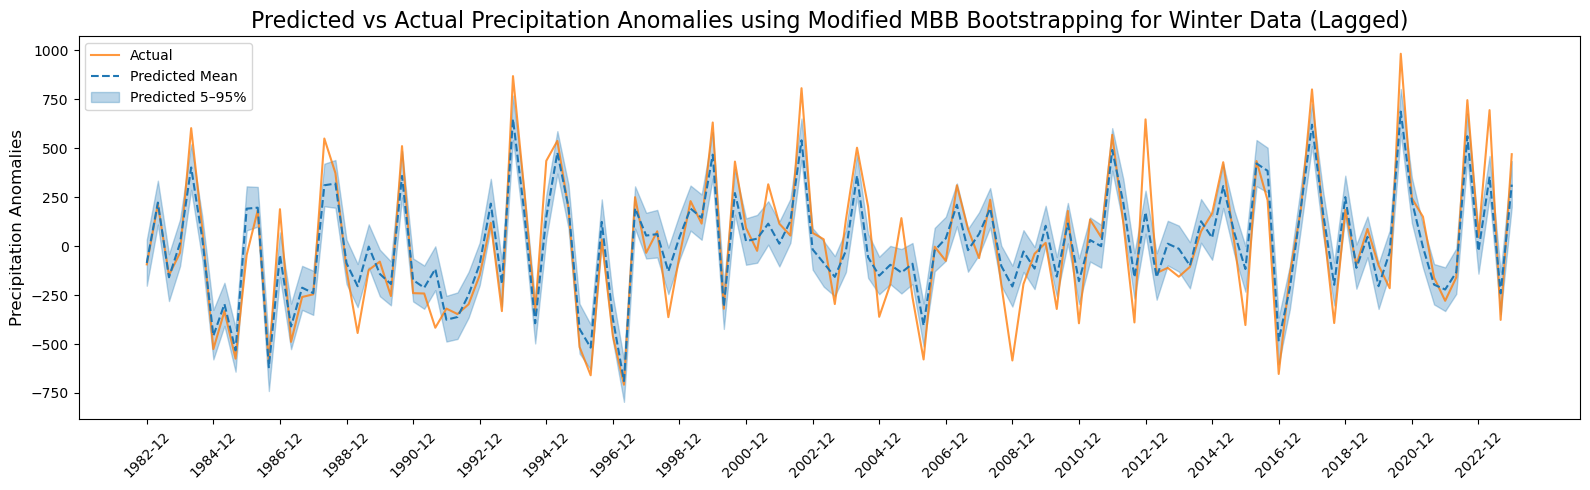

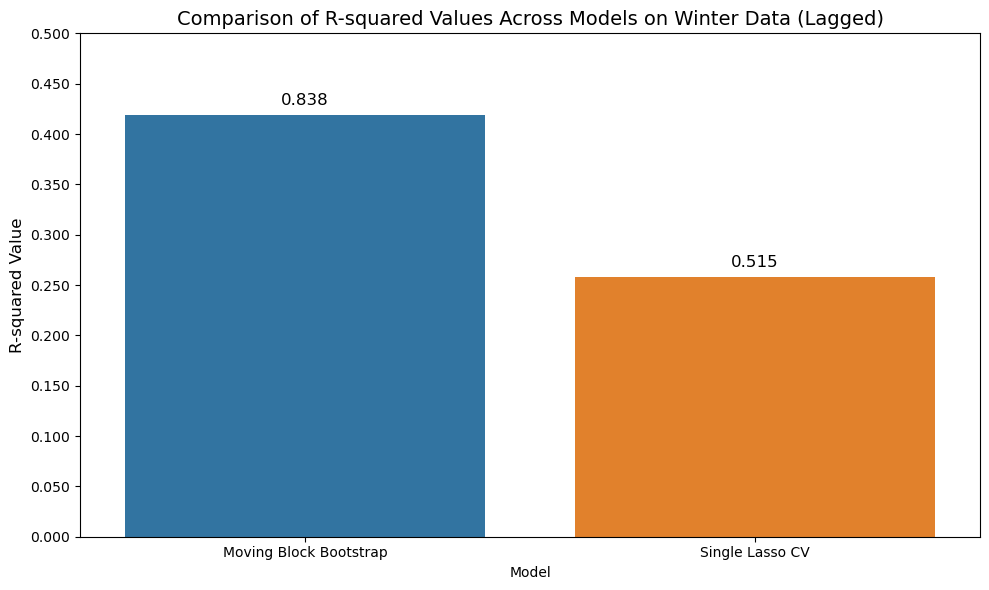

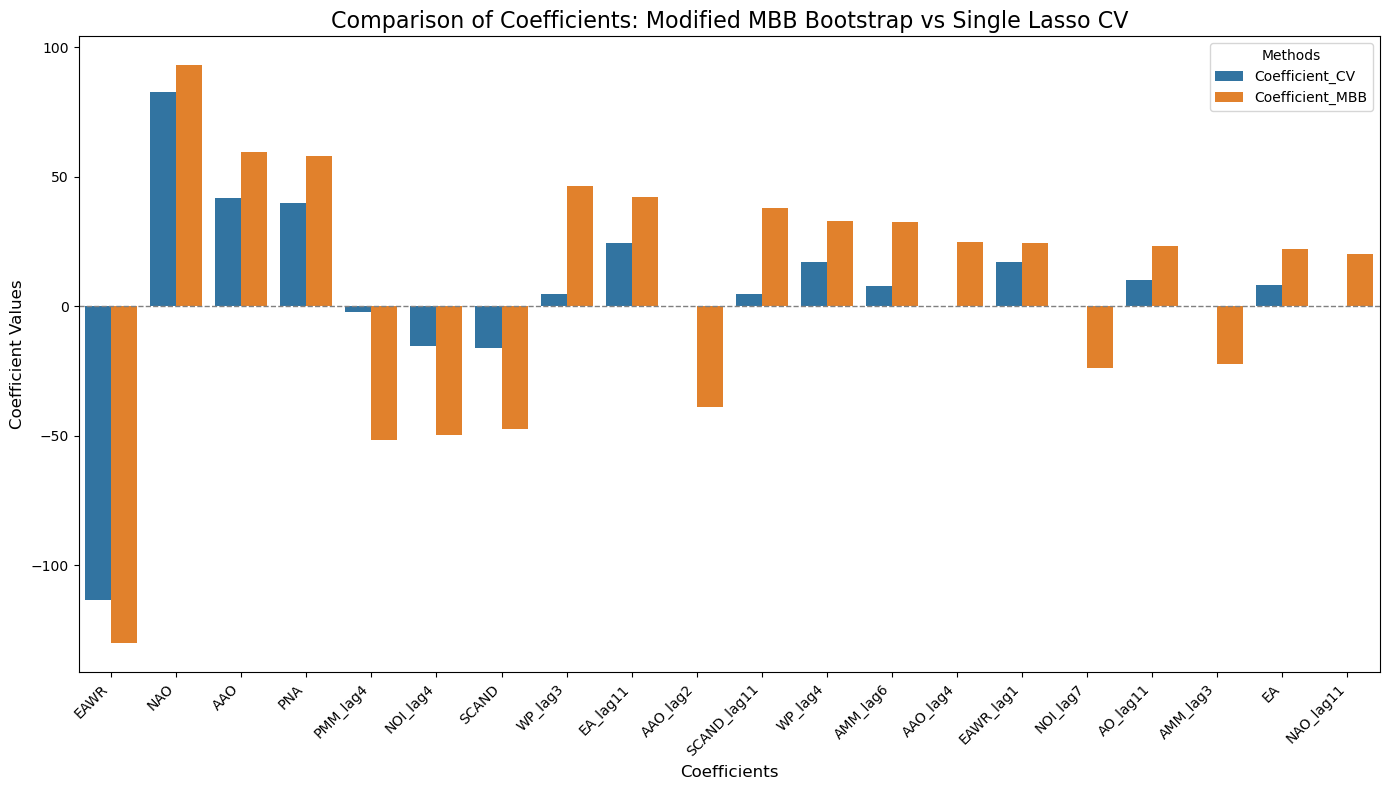

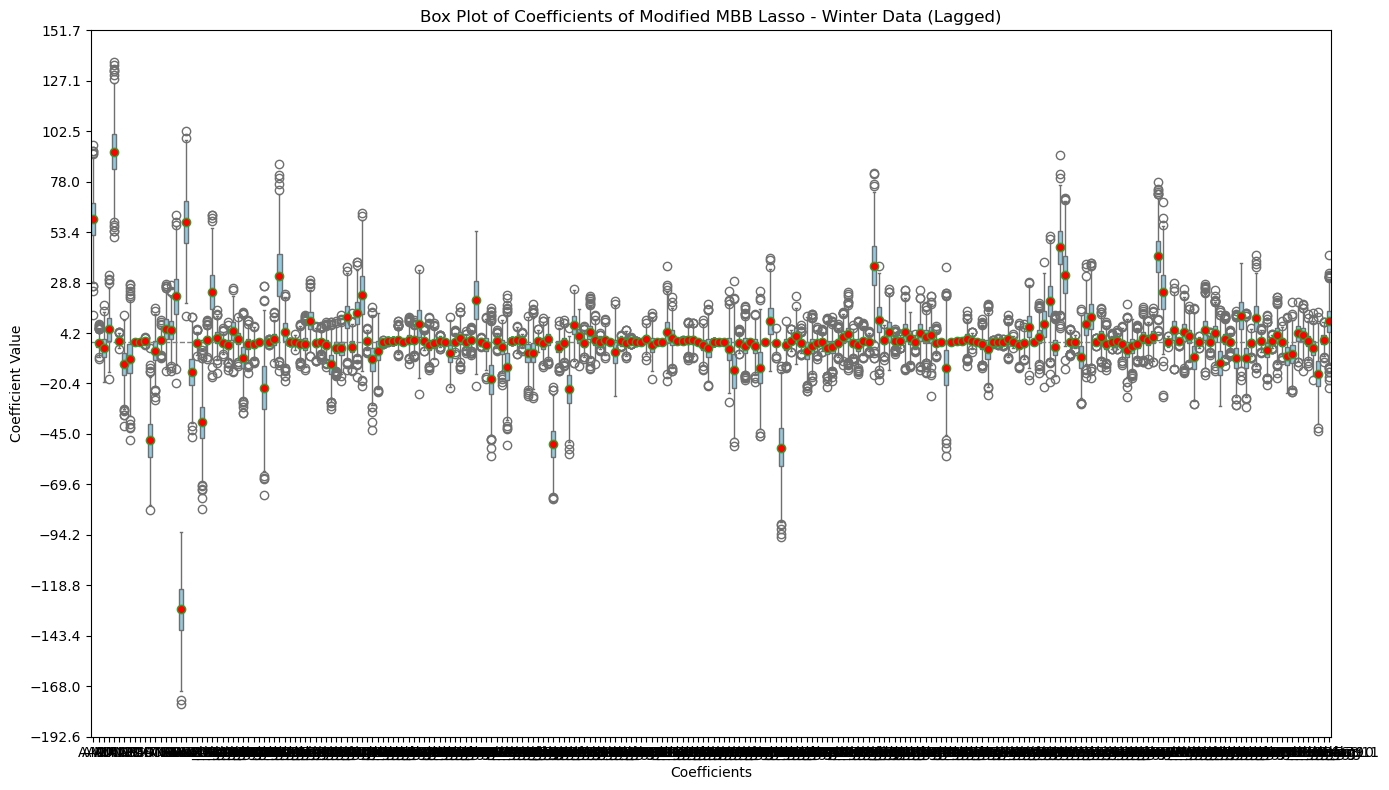

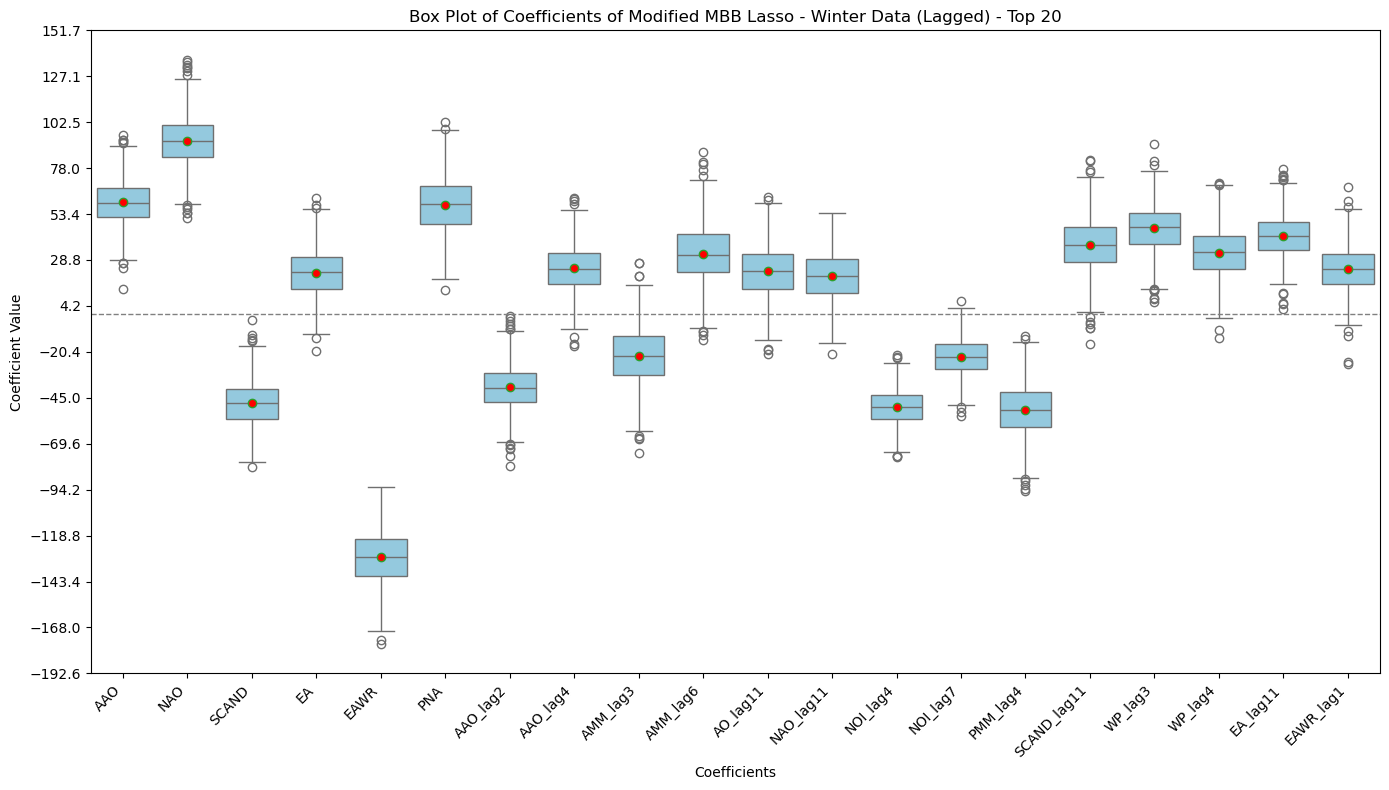

In [171]:
plt.figure(figsize=(16, 5))
plt.plot(ind, y_predicted, label="Predicted", linestyle="--", color="#1f77b4")
plt.plot(ind, y_actual, label="Actual", linestyle="-", color="#ff7f0e", alpha=0.8)
plt.title("Predicted vs Actual Precipitation Anomalies using Modified MBB Bootstrapping for Winter Data (Lagged)", fontsize=16)
plt.ylabel("Precipitation Anomalies", fontsize=12)
plt.xticks(ind[::6],rotation=45, fontsize=10)
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig(r"C:\Users\archi\OneDrive\Documents\GitHub\bootstrap_case_study\model_all\figures\predicted_vs_actual_winter_LAG.png", dpi=300, bbox_inches="tight")
plt.show()
######################################

plt.figure(figsize=(16, 5))
plt.plot(ind, y_actual, label="Actual", linestyle="-", color="#ff7f0e", alpha=0.8)
plt.plot(ind, y_predicted, label="Predicted Mean", linestyle="--", color="#1f77b4")
plt.fill_between(ind, y_p5, y_p95, color="#1f77b4", alpha=0.3, label="Predicted 5–95%")
plt.title("Predicted vs Actual Precipitation Anomalies using Modified MBB Bootstrapping for Winter Data (Lagged)", fontsize=16)
plt.ylabel("Precipitation Anomalies", fontsize=12)
plt.xticks(ind[::6], rotation=45, fontsize=10)  # Adjust x-axis ticks for better readability
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig(r"C:\Users\archi\OneDrive\Documents\GitHub\bootstrap_case_study\model_all\figures\predicted_vs_actual_winter_confint_LAG.png", dpi=300, bbox_inches="tight")
plt.show()


#R2

r_mbb = calculate_r2(y_actual, y_predicted)
r_lass = results_cv_lasso_winter['r2_score']
r_squared_df = pd.DataFrame({
    "Model": ["Moving Block Bootstrap", "Single Lasso CV"],
    "R-squared": [r_mbb, r_lass]
})

plt.figure(figsize=(10, 6))

# Custom color palette for the barplot
custom_colors = ["#1f77b4", "#ff7f0e"]

sns.barplot(data=r_squared_df, x="Model", y="R-squared", palette=custom_colors)
plt.title("Comparison of R-squared Values Across Models on Winter Data (Lagged)", fontsize=14)
plt.ylabel("R-squared Value", fontsize=12)
plt.ylim(0, 1)

# Add custom y-ticks
plt.yticks(ticks=[i/500 for i in range(0, 501, 50)], labels=[f"{i/1000:.3f}" for i in range(0, 501, 50)])

# Add R-squared values as text above bars
for index, row in r_squared_df.iterrows():
    plt.text(index, row["R-squared"] + 0.02, f"{row['R-squared']:.3f}", ha='center', fontsize=12)
    
plt.tight_layout()
plt.savefig(r"C:\Users\archi\OneDrive\Documents\GitHub\bootstrap_case_study\model_all\figures\MBB_Lasso_R2_LAG.png", dpi=300, bbox_inches="tight")
plt.show()

#########################################
cv = dict(zip(results_lags_lasso_winter['lagged_columns'], results_lags_lasso_winter['coefficients_single']))
df_cv = pd.DataFrame.from_dict(cv, orient='index', columns=['Coefficient'])
df_cv.index.name = 'Lagged Columns'

df_cv_mbb = dict(zip(X.columns, coefficients_mean))
df_cv_mbb  = pd.DataFrame.from_dict(df_cv_mbb , orient='index', columns=['Coefficient'])
df_cv_mbb.index.name = 'Lagged Columns'

df = df_cv.join(df_cv_mbb, how='inner', lsuffix='_CV', rsuffix='_MBB')
df['abs'] = df['Coefficient_MBB'].abs()
df = df.sort_values(['abs'], ascending = False)
df = df.drop(['abs'], axis = 1)
df = df.reset_index()

df_top10 = df.head(20)
df_melted = df_top10.melt(id_vars='Lagged Columns', 
                          value_vars=['Coefficient_CV', 'Coefficient_MBB'], 
                          var_name='Coefficient Type', 
                          value_name='Coefficient Value')

# Plot
plt.figure(figsize=(14, 8))
sns.barplot(data=df_melted, x='Lagged Columns', y='Coefficient Value', 
            hue='Coefficient Type', palette=["#1f77b4", "#ff7f0e"])
plt.title('Comparison of Coefficients: Modified MBB Bootstrap vs Single Lasso CV', fontsize=16)
plt.xlabel('Coefficients', fontsize=12)
plt.ylabel('Coefficient Values', fontsize=12)
plt.legend(title='Methods')
plt.xticks(rotation=45, ha="right")
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
#plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(r"C:\Users\archi\OneDrive\Documents\GitHub\bootstrap_case_study\model_all\figures\Coeff_com_winter_LAG.png", dpi=300, bbox_inches="tight")
plt.show()
##################################################################

custom_x_labels = list(X.columns)
coefficients = np.random.normal(
    loc=coefficients_mean,
    scale=np.abs(confidence_intervals[:, 1] - confidence_intervals[:, 0]) / 4,
    size=(num_bootstrap, len(coefficients_mean))
)
coeff_data = {
    "Coefficients": np.tile(custom_x_labels, num_bootstrap),
    "Values": coefficients.flatten(),
}
coeff_df = pd.DataFrame(coeff_data)
plt.figure(figsize=(14, 8))
sns.boxplot(x="Coefficients", y="Values", data=coeff_df, showmeans=True, meanprops={"marker": "o", "markerfacecolor": "red"}, color = 'skyblue')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
y_min, y_max = plt.ylim()
y_ticks = np.linspace(y_min, y_max, num=15)
plt.yticks(y_ticks)
plt.title("Box Plot of Coefficients of Modified MBB Lasso - Winter Data (Lagged)")
plt.ylabel("Coefficient Value")
plt.xticks(ticks=range(len(custom_x_labels)), labels=custom_x_labels)
plt.tight_layout()
plt.savefig(r"C:\Users\archi\OneDrive\Documents\GitHub\bootstrap_case_study\model_all\figures\MBB_Lasso_box_LAG.png", dpi=300, bbox_inches="tight")
plt.show()
###############################################################
# Flatten coefficients and create a DataFrame with absolute values
coeff_data = {
    "Coefficients": np.tile(custom_x_labels, num_bootstrap),
    "Values": coefficients.flatten(),
}
coeff_df = pd.DataFrame(coeff_data)
mean_coefficients = coeff_df.groupby("Coefficients")["Values"].mean().abs().sort_values(ascending=False)
top_20_coefficients = mean_coefficients.head(20).index
coeff_df = coeff_df[coeff_df["Coefficients"].isin(top_20_coefficients)]
plt.figure(figsize=(14, 8))

sns.boxplot(
    x="Coefficients", 
    y="Values", 
    data=coeff_df, 
    showmeans=True, 
    meanprops={"marker": "o", "markerfacecolor": "red"}, 
    color='skyblue'
)

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
y_min, y_max = plt.ylim()
y_ticks = np.linspace(y_min, y_max, num=15)
plt.yticks(y_ticks)
plt.title("Box Plot of Coefficients of Modified MBB Lasso - Winter Data (Lagged) - Top 20")
plt.ylabel("Coefficient Value")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(r"C:\Users\archi\OneDrive\Documents\GitHub\bootstrap_case_study\model_all\figures\MBB_Lasso_box_TOP20_LAG.png", dpi=300, bbox_inches="tight")
plt.show()

####################################################